# Assignement 2 H2O AutoML

**The Bank Customer Churn dataset contains the following features:**

1.CustomerID

2.Credit Score

3.Country

4.Gender

5.Age

6.Tenure

7.Balance

8.Product Number

9.Credit Card

10.Active Member

11.Estimated Salary

12.Churn

# Importing packages and dataset

In [6]:
#importing packages
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
from scipy import stats # entropy calculation
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf #OLS model Library

In [7]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 4.8 MB/s eta 0:00:00


In [8]:
import h2o
from h2o.automl import H2OAutoML
import psutil

In [9]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [10]:
min_mem_size=6
run_time=222

In [11]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


In [12]:
port_no=random.randint(5555,55555)

try:
    h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
    logging.critical('h2o.init')
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:25740..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpszu8yszl
  JVM stdout: /tmp/tmpszu8yszl/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpszu8yszl/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:25740
Connecting to H2O server at http://127.0.0.1:25740 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         14 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    5 days
H2O_cluster_name:           H2O_from_python_unknownUser_qkrl6u
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:25740
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [13]:
df = pd.read_csv("https://raw.githubusercontent.com/anshvaghela2099/INFO-6105/main/Bank_Customer_Churn_Prediction.csv")

In [14]:
#removing column customerid as it will not have an impact on our analysis
df.drop(columns=['customer_id'], inplace=True)

In [15]:
from scipy import stats

# Generating Data Summary

Entroy is used to understand the distribution of data in the features

In [16]:
def summarytable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['Sample Value'] = df.loc[0].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2)
    return summary

summarytable(df)

Dataset Shape: (10000, 11)


Name   dtypes  Missing  Uniques Sample Value  Entropy
0       credit_score    int64        0      460          619     2.55
1            country   object        0        3       France     0.45
2             gender   object        0        2       Female     0.30
3                age    int64        0       70           42     1.60
4             tenure    int64        0       11            2     1.03
5            balance  float64        0     6382          0.0     2.71
6    products_number    int64        0        4            1     0.36
7        credit_card    int64        0        2            1     0.26
8      active_member    int64        0        2            1     0.30
9   estimated_salary  float64        0     9999    101348.88     4.00
10             churn    int64        0        2            1     0.22

# Numerical and Categorical Columns

In [17]:
#numeric columns
num_cols = df.select_dtypes('number').columns
num_cols

Index(['credit_score', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'churn'],
      dtype='object')

In [18]:
#categorical columns
catg_cols = df.select_dtypes('object').columns
catg_cols

Index(['country', 'gender'], dtype='object')

# Numerical Columns

credit_score

age

tenure

balance

products_number

credit_card

active_member

estimated salary

churn

# Categorical Columns

country

gender

In [19]:
df.describe()

credit_score           age        tenure        balance  \
count  10000.000000  10000.000000  10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288   
std       96.653299     10.487806      2.892174   62397.405202   
min      350.000000     18.000000      0.000000       0.000000   
25%      584.000000     32.000000      3.000000       0.000000   
50%      652.000000     37.000000      5.000000   97198.540000   
75%      718.000000     44.000000      7.000000  127644.240000   
max      850.000000     92.000000     10.000000  250898.090000   

       products_number  credit_card  active_member  estimated_salary  \
count     10000.000000  10000.00000   10000.000000      10000.000000   
mean          1.530200      0.70550       0.515100     100090.239881   
std           0.581654      0.45584       0.499797      57510.492818   
min           1.000000      0.00000       0.000000         11.580000   
25%           1.000000      0.00000       0.000000      51002.110000   
50%           1.000000      1.00000       1.000000     100193.915000   
75%           2.000000      1.00000       1.000000     149388.247500   
max           4.000000      1.00000       1.000000     199992.480000   

              churn  
count  10000.000000  
mean       0.203700  
std        0.402769  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

# Column Distributions

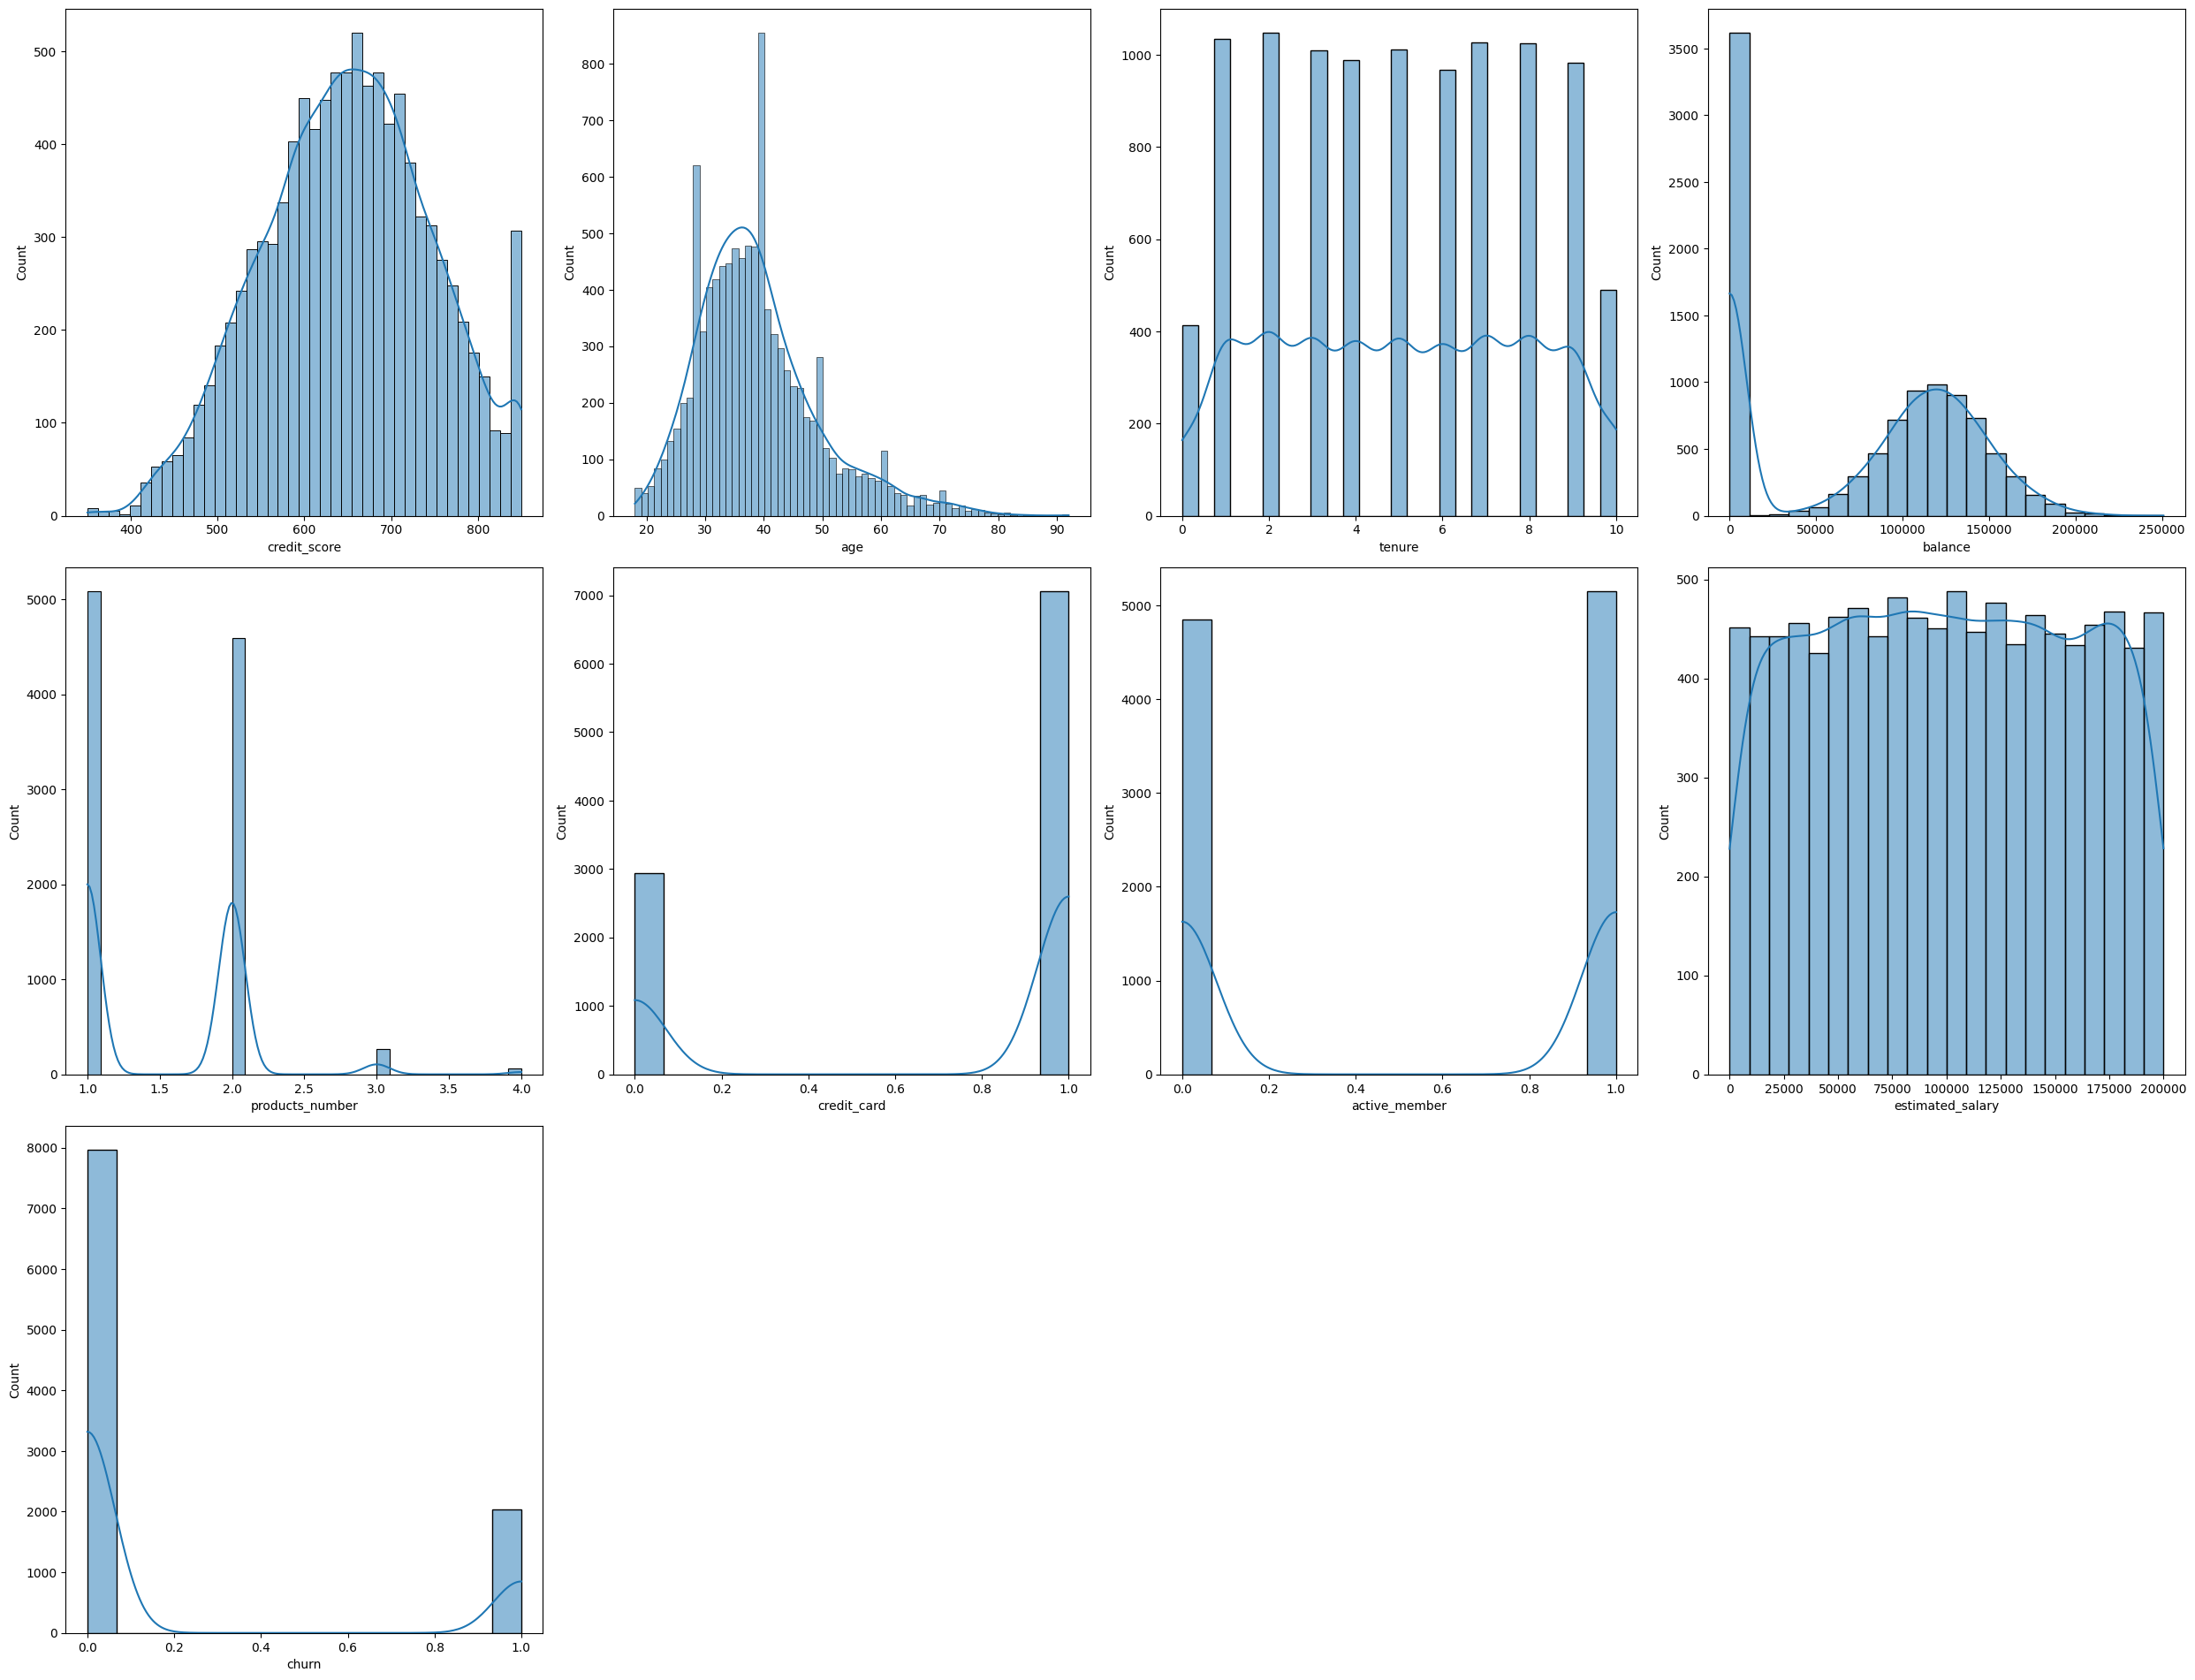

In [20]:
rows = 4
cols = 4
counter = 1
plt.rcParams['figure.figsize'] = [25,25]
for row in range(rows):
    for col in range(cols):
        if counter <= len(num_cols):
            plt.subplot(rows, cols, counter)
            sns.histplot(df[num_cols[counter - 1]], kde=True)
        counter += 1
plt.tight_layout()
plt.show()

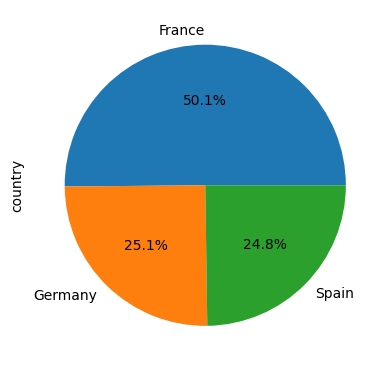

In [21]:
df['country'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(4, 4))
plt.tight_layout()
plt.show()

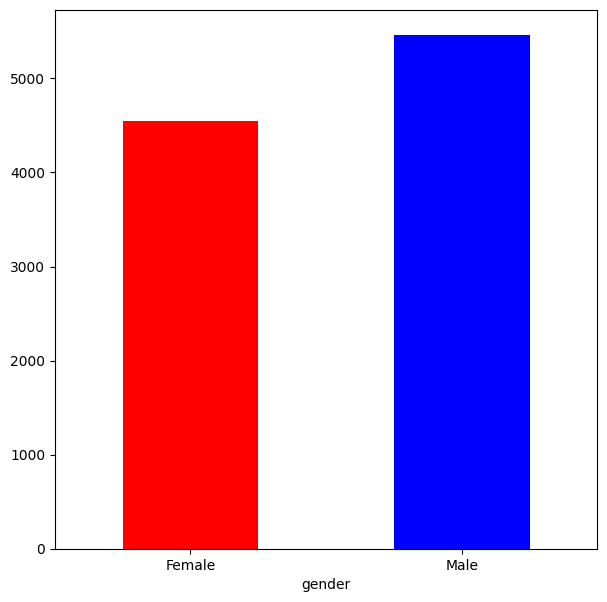

In [22]:
#gender distribution
plt.figure(figsize = (7,7))
plt_room_types = df.groupby("gender").size().plot.bar(x="gender", y= 'size', rot = 0, color=['red', 'blue'])

# Encoding Categorical Features

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [24]:
onehot_col = ['country','gender']
onehot_prefix = ['cntry','gender']
df = pd.get_dummies(df, columns=onehot_col, prefix = onehot_prefix)
for col in catg_cols:
  if col not in onehot_col:
    df[col] = LabelEncoder().fit_transform(df[col])

# Q1. Is the relationship significant?
The correlation matrix shows the relationships between the different attributes of our data set.

We can see that many variables have relationships with other variables as well.

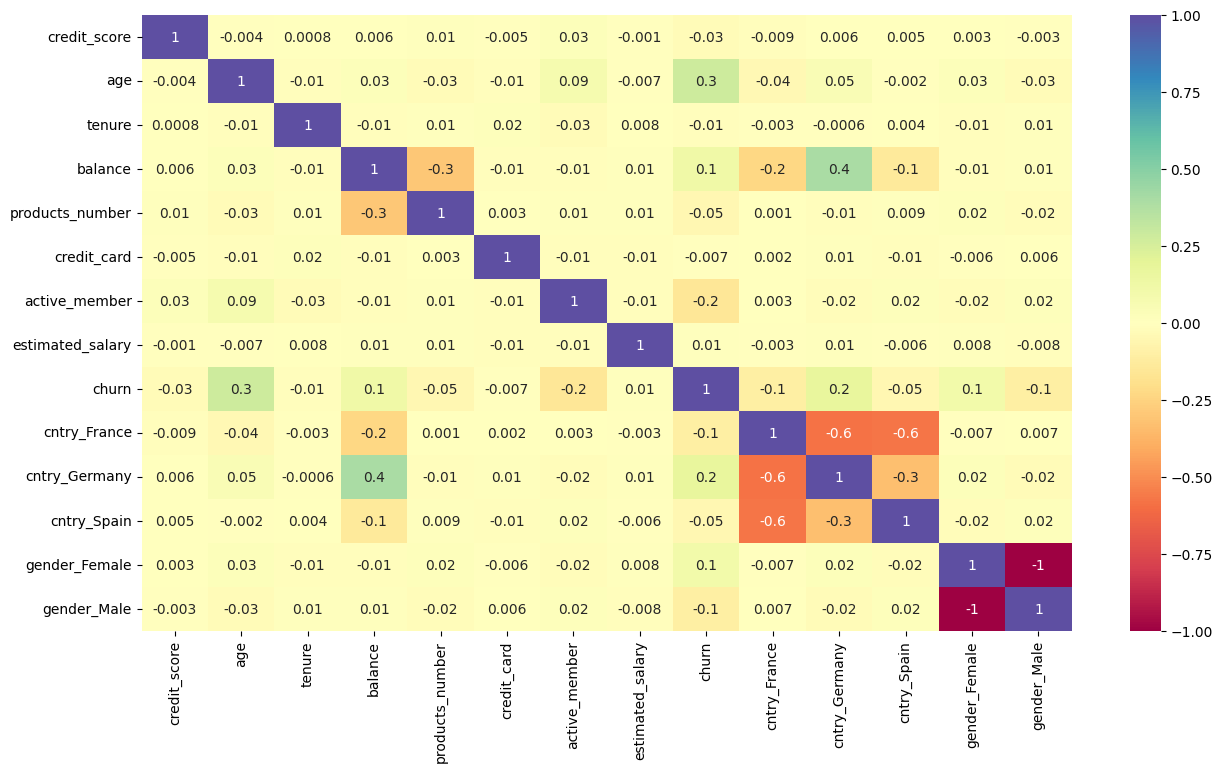

In [25]:
plt.rcParams['figure.figsize']=[15, 8]
sns.heatmap(df.corr(),  annot = True ,fmt = '.1g', vmin = -1, vmax = 1, center = 0, cmap = 'Spectral');

<Axes: >

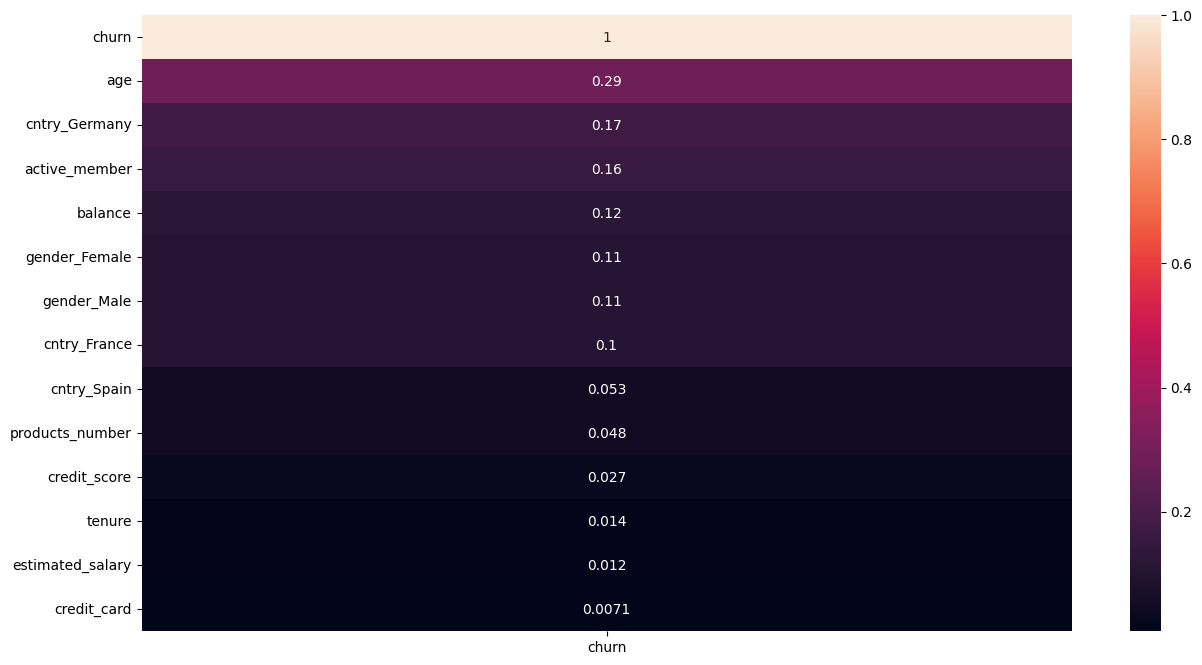

In [26]:
corr=df.corr()["churn"]
corr=corr.abs().sort_values(ascending=False)
sns.heatmap(data=corr.to_frame(),annot=True)

The most important variables are listed at the top of the heatmap, based on the absolute value of their correlation coefficient. In this case, the top variables are:

cntry_Germany (0.17)

gender_Female (0.6)

churn (0.54)

age (0.29)

cntry_France (0.1)

active_member (0.16)

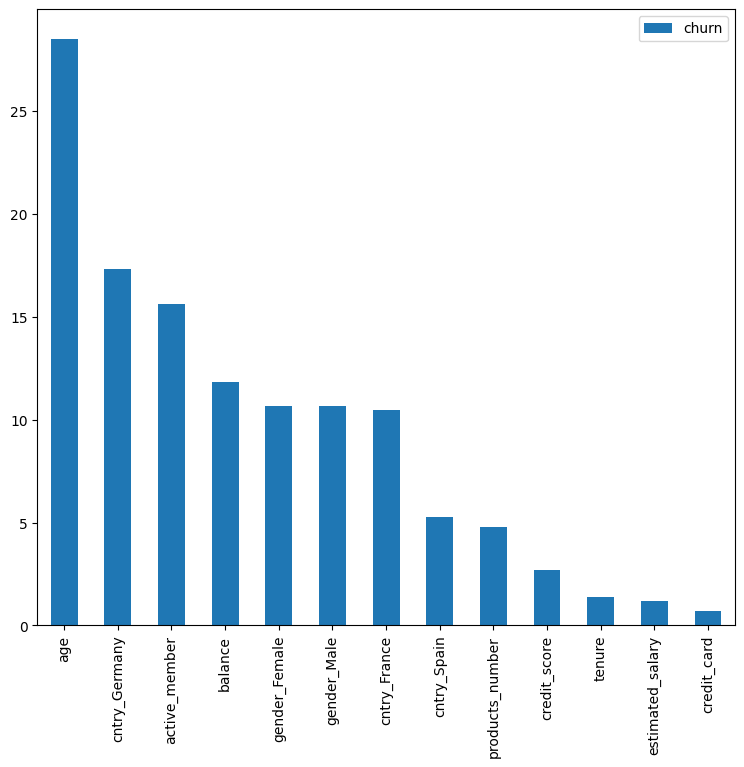

In [27]:
pd.DataFrame(abs(df.corr()['churn'].drop(['churn'])*100).sort_values(ascending=False)).plot.bar(figsize = (9,8));

# Q2. Are any model assumptions violated?

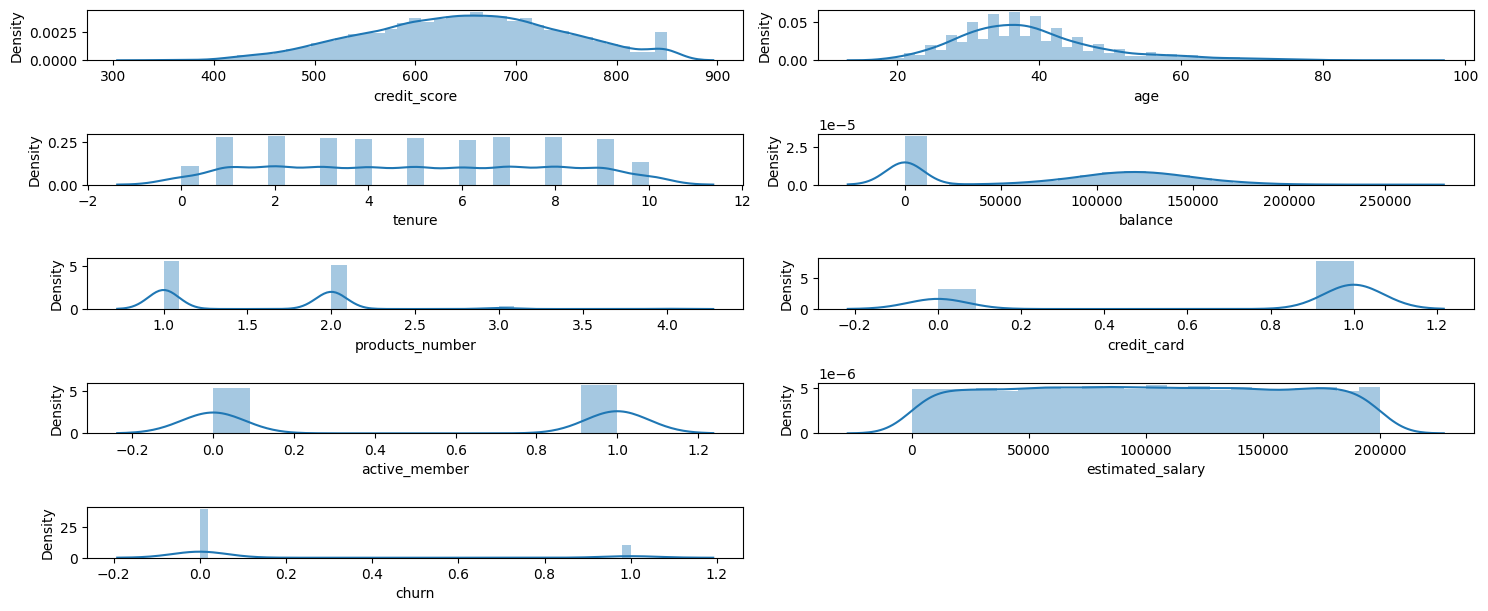

In [28]:
# Generating Distribution plots
rows=10
cols=2
#Set counter variable to 1, to keeptrack of which subplot is being plotted in the loop
counter=1
plt.rcParams['figure.figsize']=[15, 12]
for i in num_cols:
    plt.subplot(rows, cols, counter)
    sns.distplot(df[i])
    counter+=1
#subplots are properly spaced and aligned
plt.tight_layout()
plt.show()

Yes, model assumptions have been violated.

Linear Regression Model assumes that the independent variables follow a normal distribution.

Credit score and estimated salary are normally distributed

Whereas other columns such as balance is Right-Skewed.

Hence, violating model assumptions.

It is possible that due to outliers in the dataset the distributions are not properly distributed. We should replot them after eliminating the outliers.

# Removing outliers

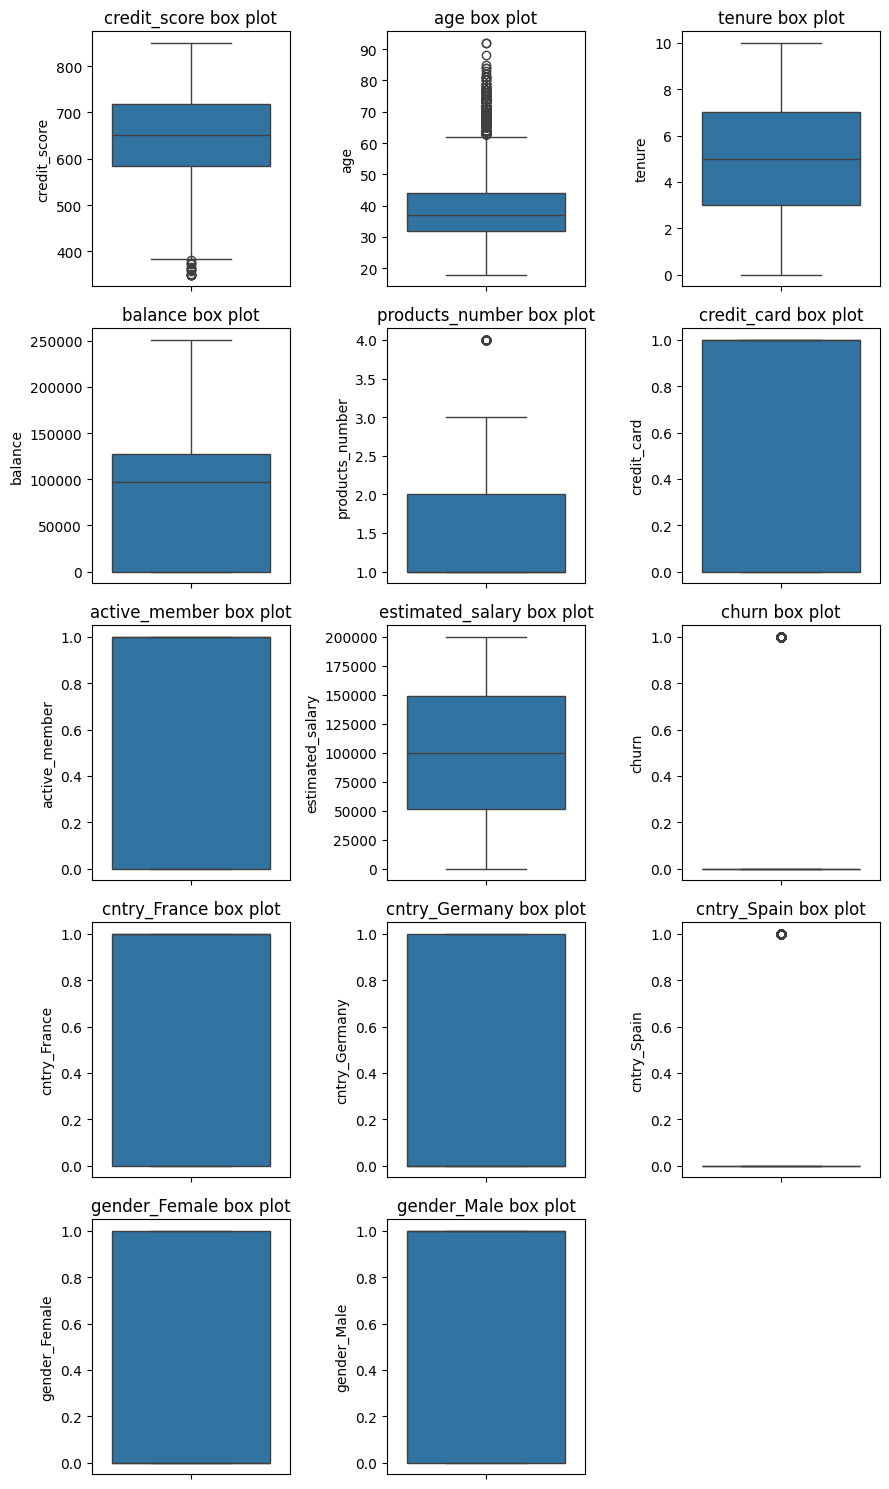

In [29]:
cols=3
rows=((len(df.columns)-1) // cols)+1
counter=1
plt.rcParams['figure.figsize']=[3*cols, 3*rows]
for c in df.columns:
    plt.subplot(rows, cols, counter)
    sns.boxplot(df[c])
    plt.title("{} box plot".format(c), size=12)
    counter+=1
plt.tight_layout()
plt.show()

<Axes: >

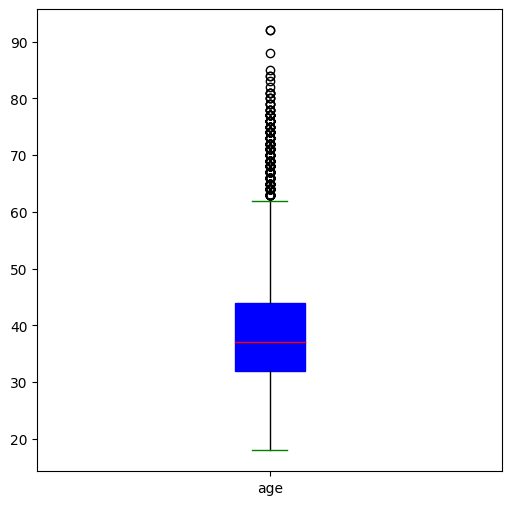

In [30]:
age=df['age']
plt.figure(figsize=(6,6))
props2= dict(boxes='blue',whiskers='black',medians='red',caps='green')
age.plot.box(color=props2,patch_artist=True,vert=True)

In [31]:
def find_boundaries(df,feature):
    Q1=df[feature].quantile(.25)
    Q3=df[feature].quantile(.75)
    IQR=Q3-Q1
    lower_boundary=Q1-1.5*IQR
    upper_boundary=Q3+1.5*IQR

    return lower_boundary,upper_boundary

In [32]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

In [33]:
def remove_outlier(df_in,feature):
    Q1=df_in[feature].quantile(.25)
    Q3=df_in[feature].quantile(.75)
    IQR=Q3-Q1
    lower_boundary=Q1-1.5*IQR
    upper_boundary=Q3+1.5*IQR
    df_out=df_in.loc[(df_in[feature]>lower_boundary) & (df_in[feature]<upper_boundary)]

    return df_out

In [34]:
lower_age,upper_age=find_boundaries(df,'age')
print(lower_age,upper_age)

14.0 62.0


In [35]:
outliers = find_outliers_IQR(df['age'])
print('number of outliers: '+ str(len(outliers)))

number of outliers: 359


In [36]:
df= remove_outlier(df,'age')

<Axes: >

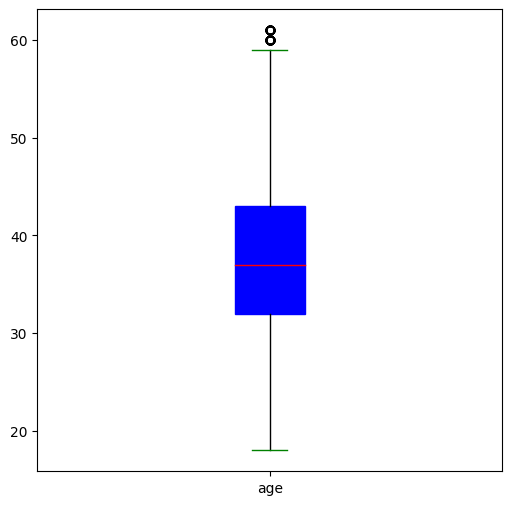

In [37]:
age=df['age']
plt.figure(figsize=(6,6))
props2= dict(boxes='blue',whiskers='black',medians='red',caps='green')
age.plot.box(color=props2,patch_artist=True,vert=True)

<Axes: >

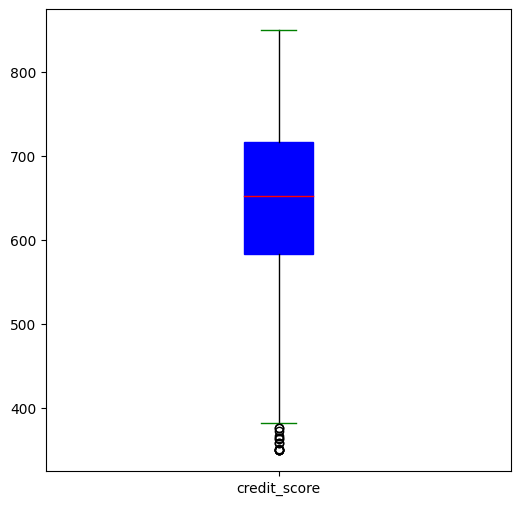

In [38]:
credit_score=df['credit_score']
plt.figure(figsize=(6,6))
props2= dict(boxes='blue',whiskers='black',medians='red',caps='green')
credit_score.plot.box(color=props2,patch_artist=True,vert=True)

In [39]:
lower_credit_score,upper_credit_score=find_boundaries(df,'credit_score')
print(lower_credit_score,upper_credit_score)

outliers = find_outliers_IQR(df['credit_score'])
print('number of outliers: '+ str(len(outliers)))

382.0 918.0
number of outliers: 14


In [40]:
df= remove_outlier(df,'credit_score')

<Axes: >

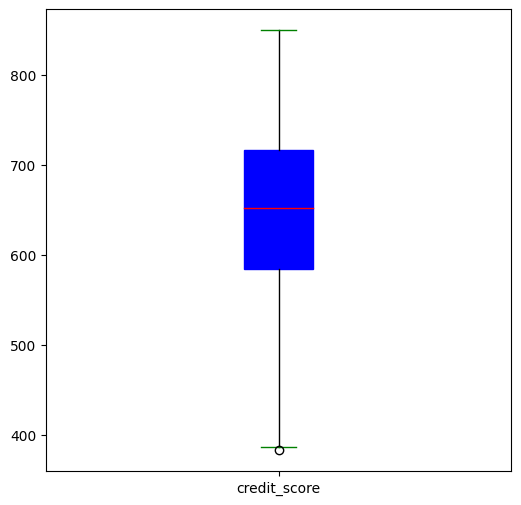

In [41]:
credit_score=df['credit_score']
plt.figure(figsize=(6,6))
props2= dict(boxes='blue',whiskers='black',medians='red',caps='green')
credit_score.plot.box(color=props2,patch_artist=True,vert=True)

# Plotting The Columns After Removing Outliers

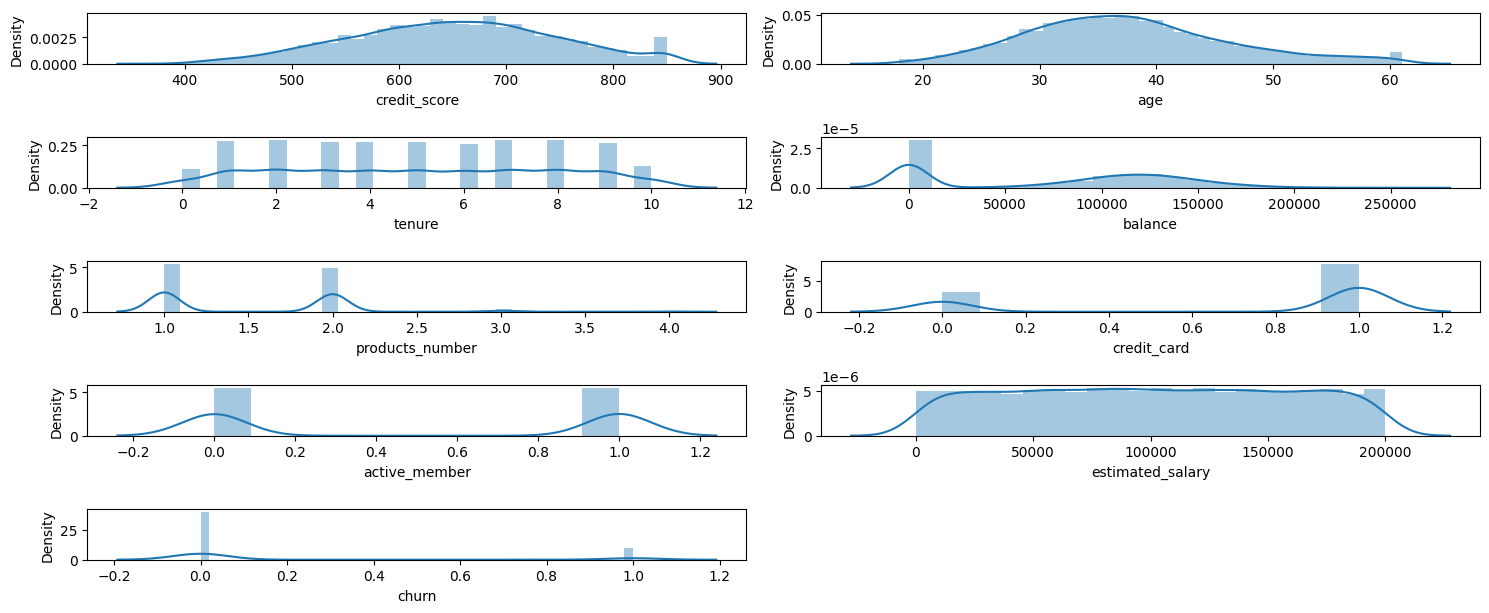

In [42]:
# Generating Distribution plots
rows=10
cols=2
#Set counter variable to 1, to keeptrack of which subplot is being plotted in the loop
counter=1
plt.rcParams['figure.figsize']=[15, 12]
for i in num_cols:
    plt.subplot(rows, cols, counter)
    sns.distplot(df[i])
    counter+=1
#subplots are properly spaced and aligned
plt.tight_layout()
plt.show()

After removing the outliers, the independent variables have distribution more like Normal.

# Q3. Is there any multicollinearity in the model?

In [43]:
numeric_cols = df.select_dtypes(exclude = "object").columns

vif_df = df[numeric_cols]
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns
vif_data["VIF"] = [variance_inflation_factor(vif_df.values ,i) for i in range(len(vif_df.columns))]
vif_data.head(25)

feature       VIF
0       credit_score  1.001121
1                age  1.155568
2             tenure  1.002149
3            balance  1.340006
4    products_number  1.124028
5        credit_card  1.001640
6      active_member  1.027048
7   estimated_salary  1.000901
8              churn  1.224836
9       cntry_France       inf
10     cntry_Germany       inf
11       cntry_Spain       inf
12     gender_Female       inf
13       gender_Male       inf

From the provided VIF results, it appears that there is no significant multicollinearity among the first eight features as their VIF values are close to 1.

However, the features related to country (cntry_France, cntry_Germany, and cntry_Spain) and gender (gender_Female and gender_Male) have infinite (inf) VIF values. This indicates perfect multicollinearity among these variables.

# Q4. In the multivariate models are predictor variables independent of all the other predictor variables?

No, from the heat map and the VIF result, we can see some predictor variables are highly related to other predictor variables

# H20 AutoML Execution

Creating H2O frame and split train / test data

In [44]:
hdf = h2o.H2OFrame(df)
hdf.shape

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


(9574, 14)

In [45]:
hdf.types

{'credit_score': 'int',
 'age': 'int',
 'tenure': 'int',
 'balance': 'real',
 'products_number': 'int',
 'credit_card': 'int',
 'active_member': 'int',
 'estimated_salary': 'real',
 'churn': 'int',
 'cntry_France': 'int',
 'cntry_Germany': 'int',
 'cntry_Spain': 'int',
 'gender_Female': 'int',
 'gender_Male': 'int'}

In [46]:
hdf['churn'] = hdf['churn'].asfactor()

In [47]:
# Create a 80/20 train/test split
pct_rows=0.80
hdf_train, hdf_test = hdf.split_frame([pct_rows])
print(hdf_train.shape)
print(hdf_test.shape)

(7582, 14)
(1992, 14)


In [48]:
X=hdf.columns
print(X)

['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn', 'cntry_France', 'cntry_Germany', 'cntry_Spain', 'gender_Female', 'gender_Male']


In [49]:
y_numeric ='churn'
X.remove(y_numeric)
print(X)

['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'cntry_France', 'cntry_Germany', 'cntry_Spain', 'gender_Female', 'gender_Male']


In [50]:
# Set up AutoML
auml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [51]:
#passing the data through H20AutoML
auml.train(x=X,y=y_numeric,training_frame=hdf_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_1_20240319_150855


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       5/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       1/1
# DRF base models (used / total)           2/2
# DeepLearning base models (used / total)  1/1
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08254678701414804
RMSE: 0.28730956652041373
LogLoss: 0.270790633885459
AUC: 0.920783168523885
AUCPR: 0.7929346336330472
Gini: 0.84156633704777
Null degrees of freedom: 7581
Residual degrees of freedom: 7576
Null deviance: 7531.197329044385
Residual deviance: 4106.2691722391
AIC: 4118.2691722391

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27307186966192676
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      5525  561   0.0922   (561.0/6086.0)
1      404   1092  0.2701   (404.0/1496.0)
Total  5929  1653  0.1273   (965.0/7582.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.273072     0.693554  214
max f2                       0.172423     0.764388  260
max f0point5                 0.553825     0.754149  121
max accuracy                 0.49498      0.887365  138
max precision                0.994707     1         0
max recall                   0.0175057    1         380
max specificity              0.994707     1         0
max absolute_mcc             0.320555     0.617181  195
max min_per_class_accuracy   0.18279      0.834893  254
max mean_per_class_accuracy  0.177333     0.837423  257
max tns                      0.994707     6086      0
max fns                      0.994707     1494      0
max fps                      0.00451326   6086      399
max tps                      0.0175057    1496      380
max tnr                      0.994707     1         0
max fnr                      0.994707     0.998663  0
max fpr                      0.00451326   1         399
max tpr                      0.0175057    1         380

Gains/Lift Table: Avg response rate: 19.73 %, avg score: 18.90 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100237                   0.954462           5.06818     5.06818            1                0.970325    1                           0.970325            0.0508021       0.0508021                  406.818   406.818            0.0508021
2        0.0200475                   0.931589           5.06818     5.06818            1                0.94265     1                           0.956487            0.0508021       0.101604                   406.818   406.818            0.101604
3        0.0300712                   0.902419           5.0015      5.04595            0.986842         0.918583    0.995614                    0.943853            0.0501337       0.151738                   400.15    404.595            0.151574
4        0

# Generating Leaderboard for Best Model

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  --------  ------------------  -------------------------  ---------------
GBM_grid_1_AutoML_1_20240319_150855_model_3              0.867199   0.3459    0.715277                0.227511  0.325696  0.106078                 519                   0.022686  GBM
StackedEnsemble_AllModels_3_AutoML_1_20240319_150855     0.866684   0.343734  0.719136                0.238319  0.324409  0.105241                3654                   0.178976  StackedEnsemble
GBM_grid_1_AutoML_1_20240319_150855_model_2              0.865551   0.346144  0.716693                0.236378  0.325666  0.106058                 754                   0.031829  GBM
StackedEnsemble_BestOfFamily_4_AutoML_1_20240319_150855  0.865473   0.345114  0.716815                0.24334   0.325142  0.105717                1594                   0.090932  StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20240319_150855     0.864811   0.346525  0.714223                0.227083  0.32557   0.105996                1663                   0.135994  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20240319_150855     0.864471   0.347061  0.710862                0.223985  0.325592  0.10601                 1321                   0.084774  StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20240319_150855  0.863651   0.348733  0.709786                0.242824  0.326435  0.10656                 1375                   0.080218  StackedEnsemble
GBM_2_AutoML_1_20240319_150855                           0.862536   0.348358  0.713058                0.227724  0.326126  0.106358                1114                   0.01938   GBM
StackedEnsemble_BestOfFamily_2_AutoML_1_20240319_150855  0.861017   0.352405  0.699607                0.229825  0.328118  0.107661                1521                   0.057977  StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20240319_150855  0.860933   0.352643  0.699331                0.24391   0.328464  0.107889                1010                   0.036493  StackedEnsemble
GBM_5_AutoML_1_20240319_150855                           0.860538   0.352529  0.701529                0.242539  0.328781  0.108097                 611                   0.02187   GBM
GBM_1_AutoML_1_20240319_150855                           0.860206   0.353185  0.697425                0.241453  0.328643  0.108006                2005                   0.024891  GBM
XGBoost_grid_1_AutoML_1_20240319_150855_model_3          0.859365   0.352713  0.707374                0.227974  0.327438  0.107216                1015                   0.008838  XGBoost
XGBoost_3_AutoML_1_20240319_150855                       0.85847    0.352488  0.706136                0.234473  0.328276  0.107765                 920                   0.008193  XGBoost
XGBoost_grid_1_AutoML_1_20240319_150855_model_7          0.857975   0.355296  0.69208                 0.241257  0.329217  0.108384                 518                   0.008309  XGBoost
GBM_3_AutoML_1_20240319_150855                           0.857814   0.353231  0.70246                 0.22557   0.328483  0.107901                1374                   0.02118   GBM
GBM_4_AutoML_1_20240319_150855                           0.857632   0.354926  0.699188                0.228543  0.329378  0.10849                  690                   0.020818  GBM
XGBoost_grid_1_AutoML_1_20240319_150855_model_2          0.854358   0.360616  0.695471                0.236147  0.331986  0.110215                 888                   0.010674  XGBoost
XGBoost_grid_1_AutoML_1_20240319_150855_model_5          0.850963   0.365675  0.687195                0.239049  0.333527  0.11124                 1032                   0.010091  XGBoost
XGBoost_1_AutoML_1_20240319_150855      

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_4_AutoML_1_20240319_150855

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38111480303949696
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      1458  102  0.0654   (102.0/1560.0)
1      182   250  0.4213   (182.0/432.0)
Total  1640  352  0.1426   (284.0/1992.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

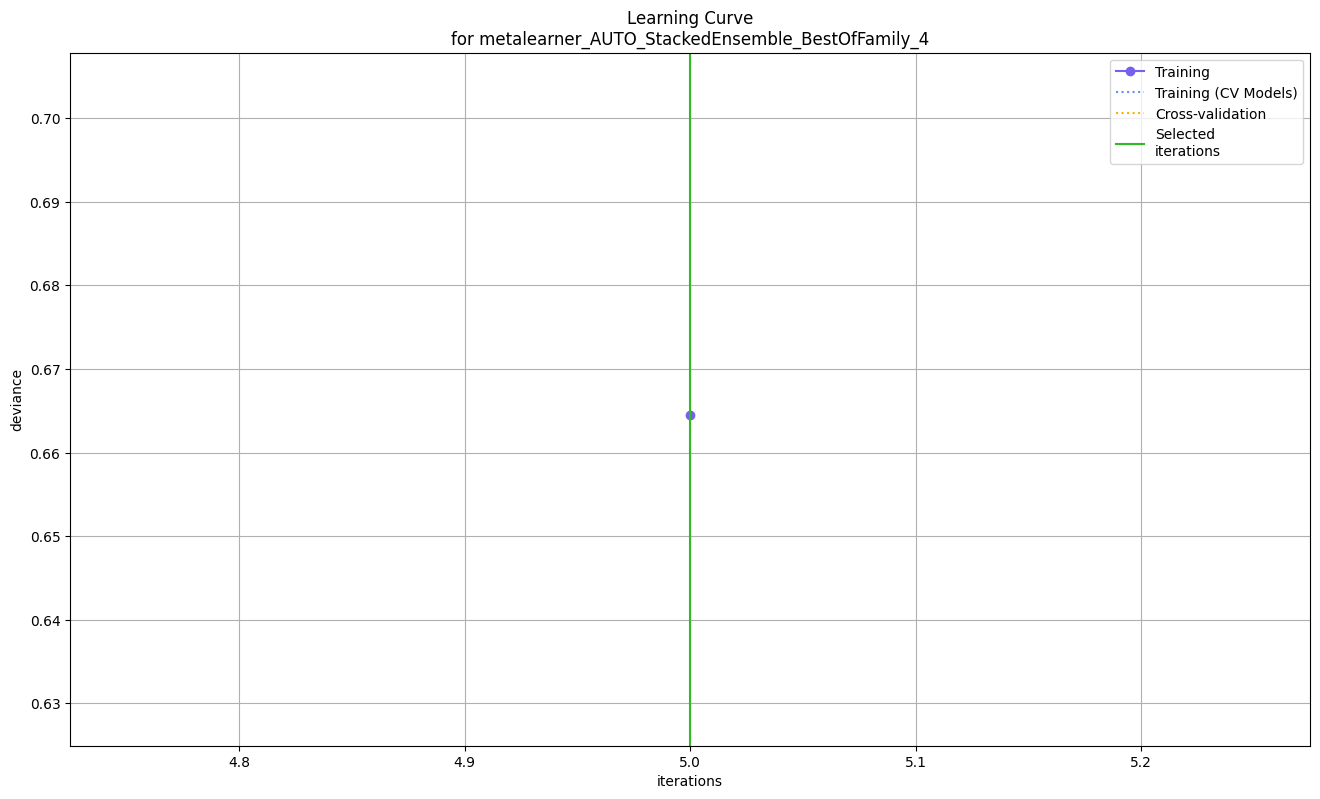

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

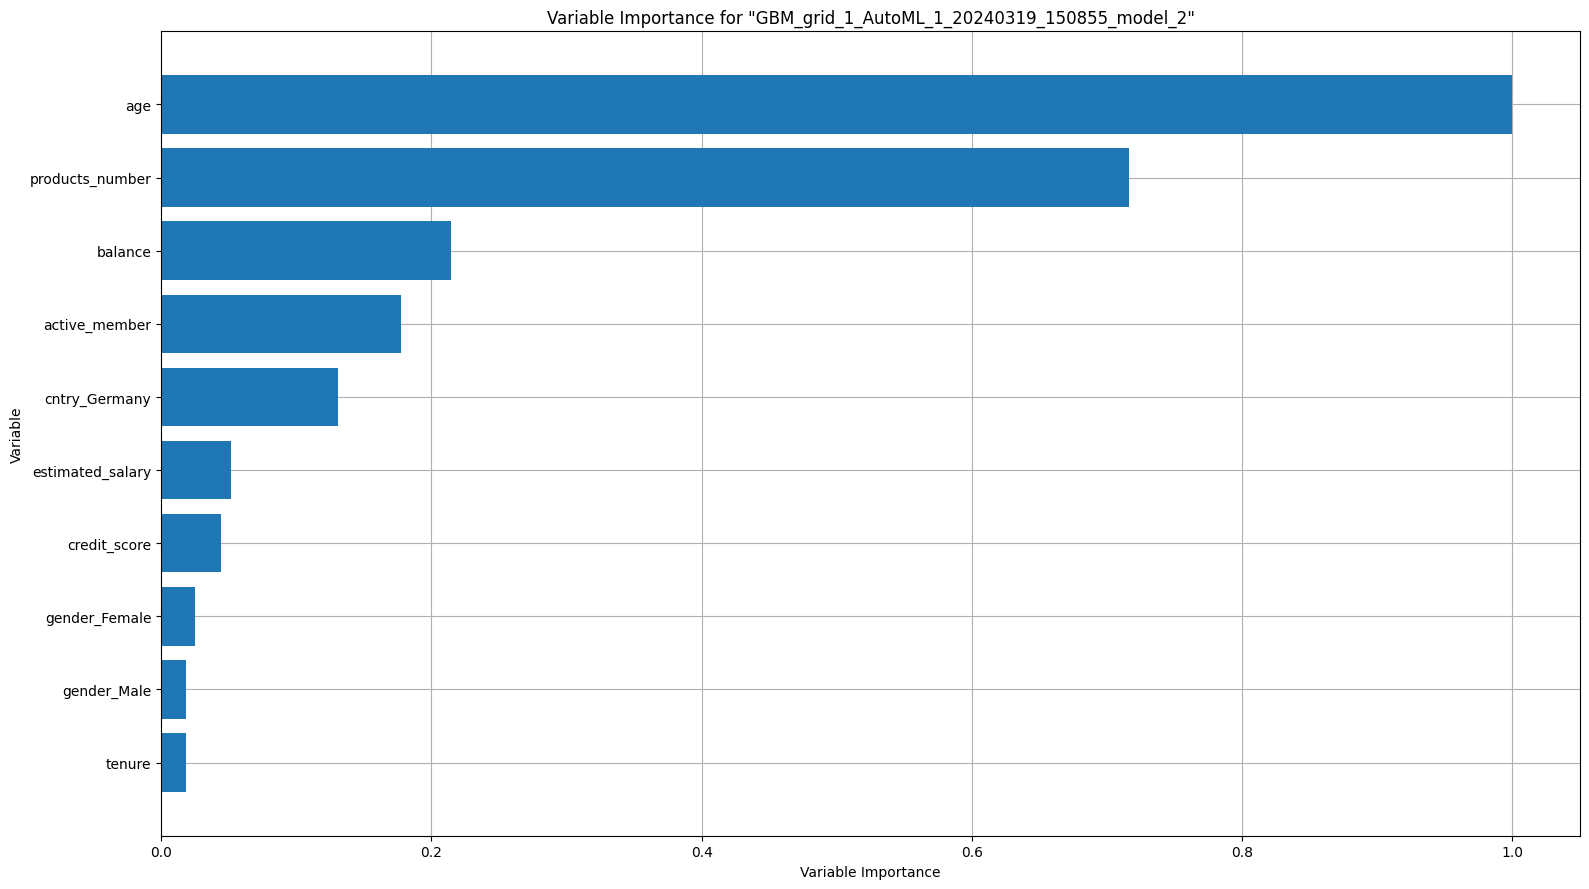

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

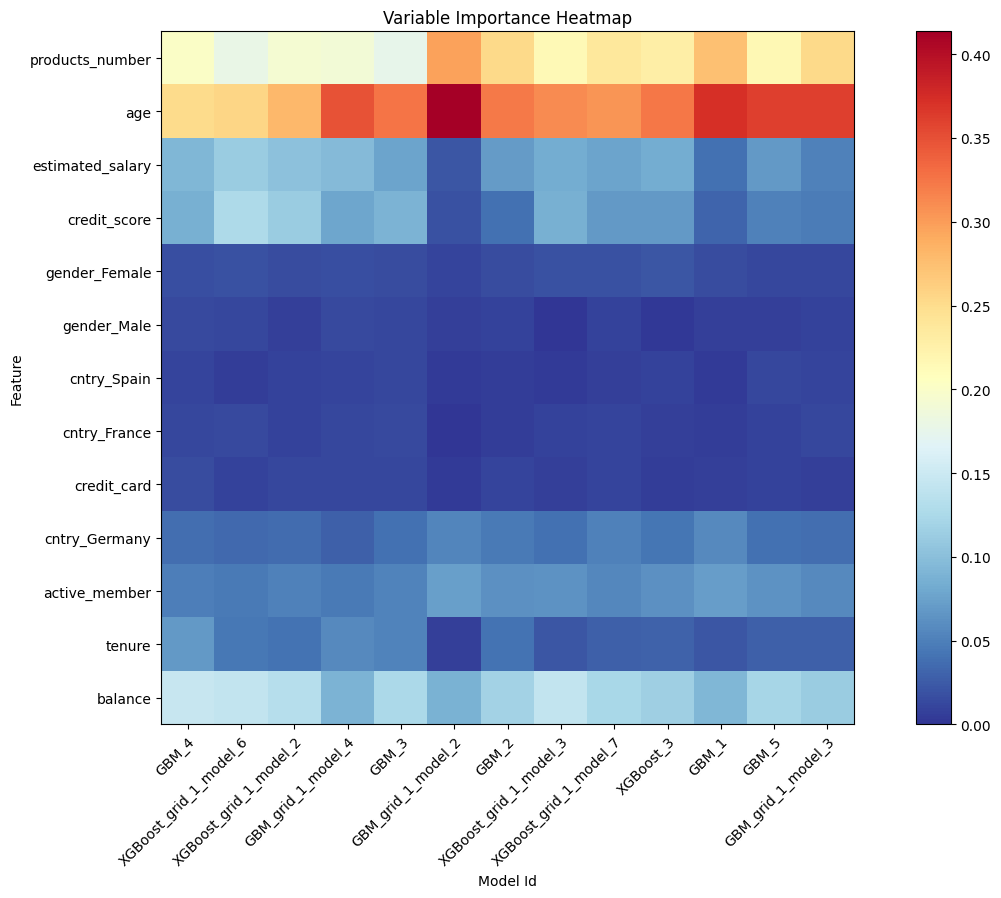

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

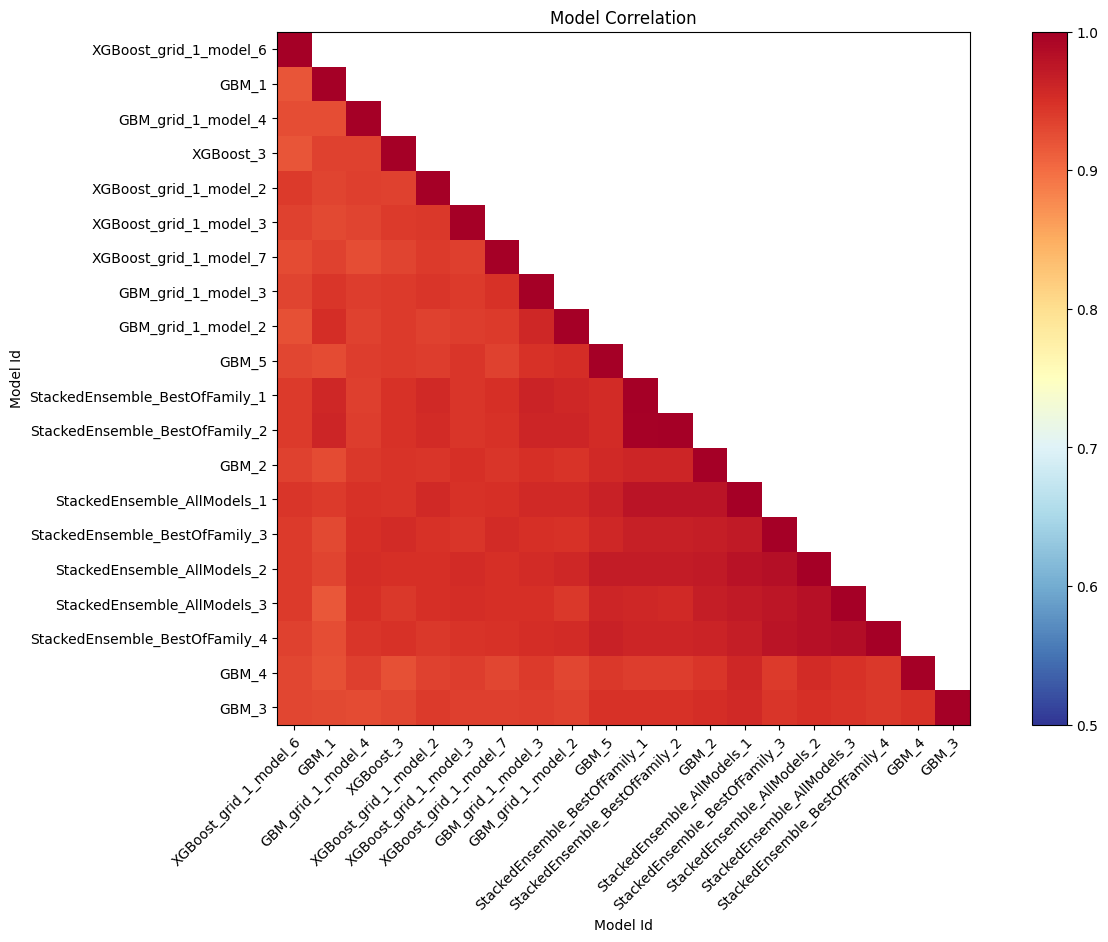

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

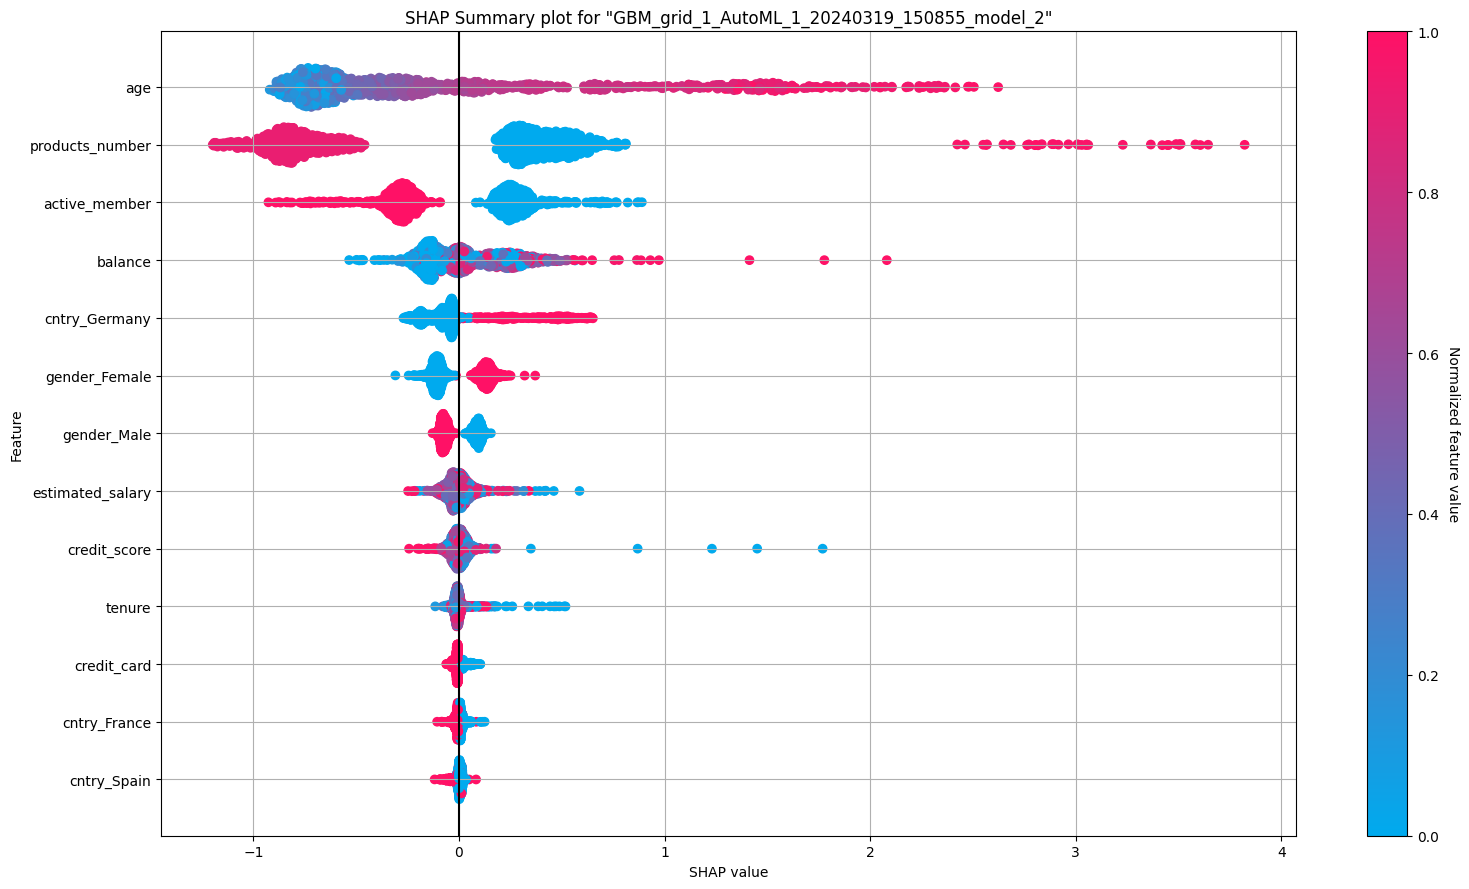

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

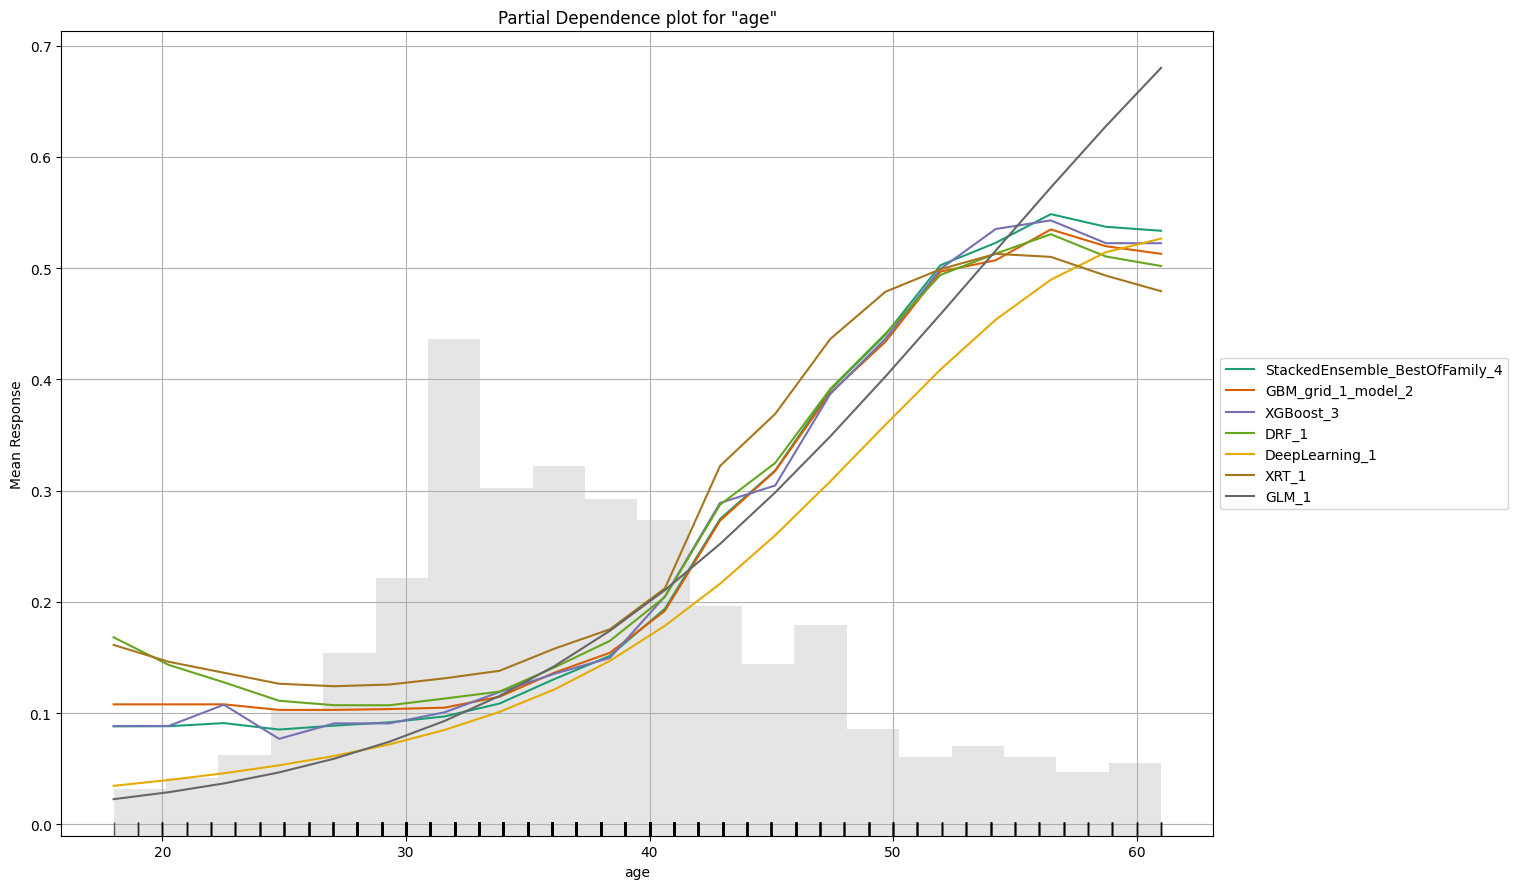

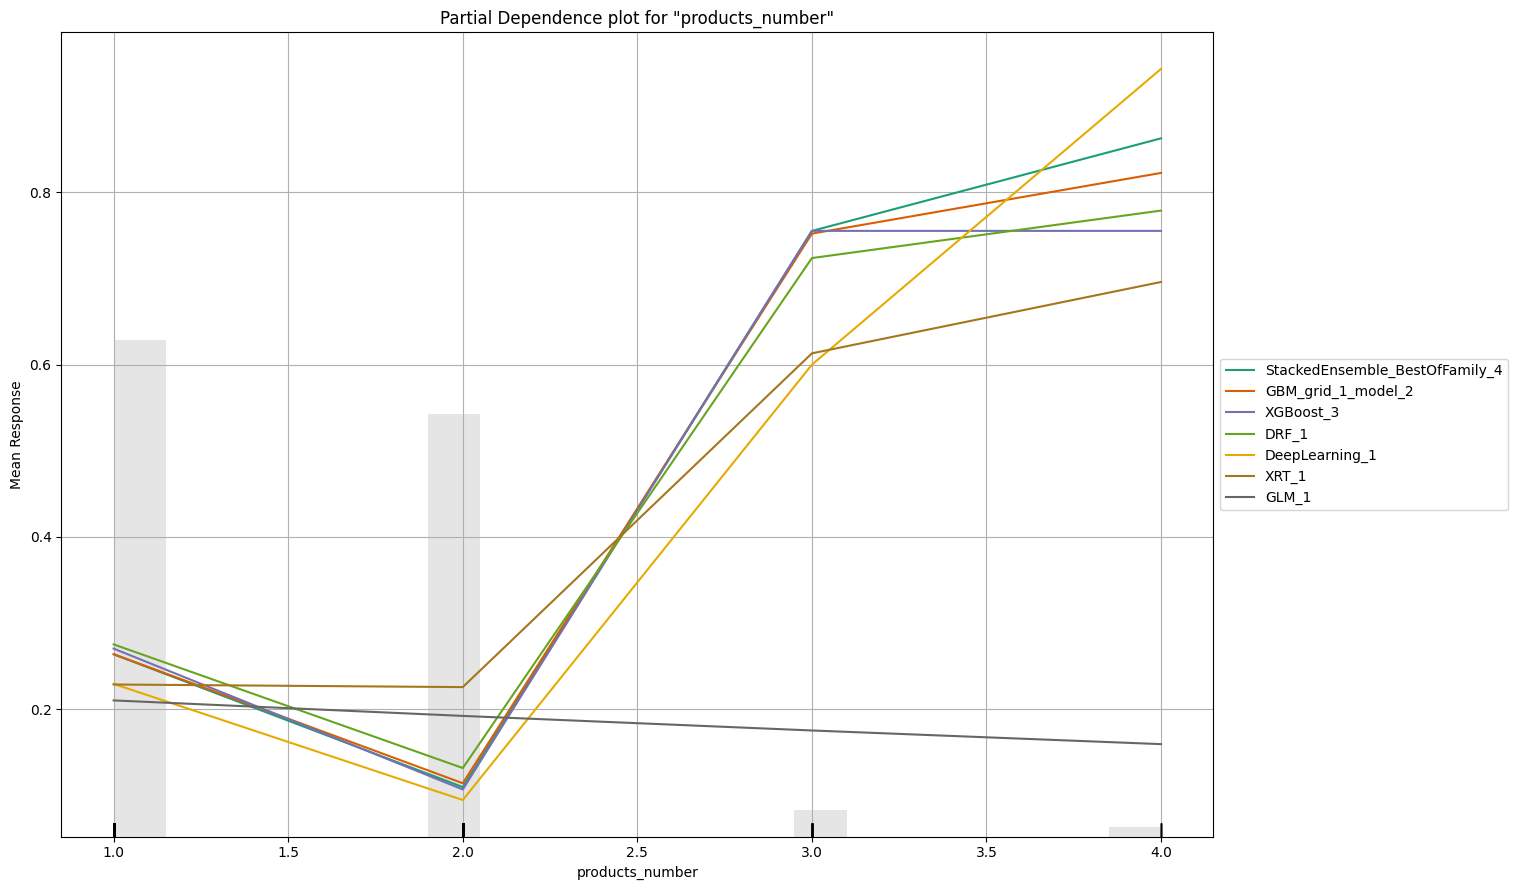

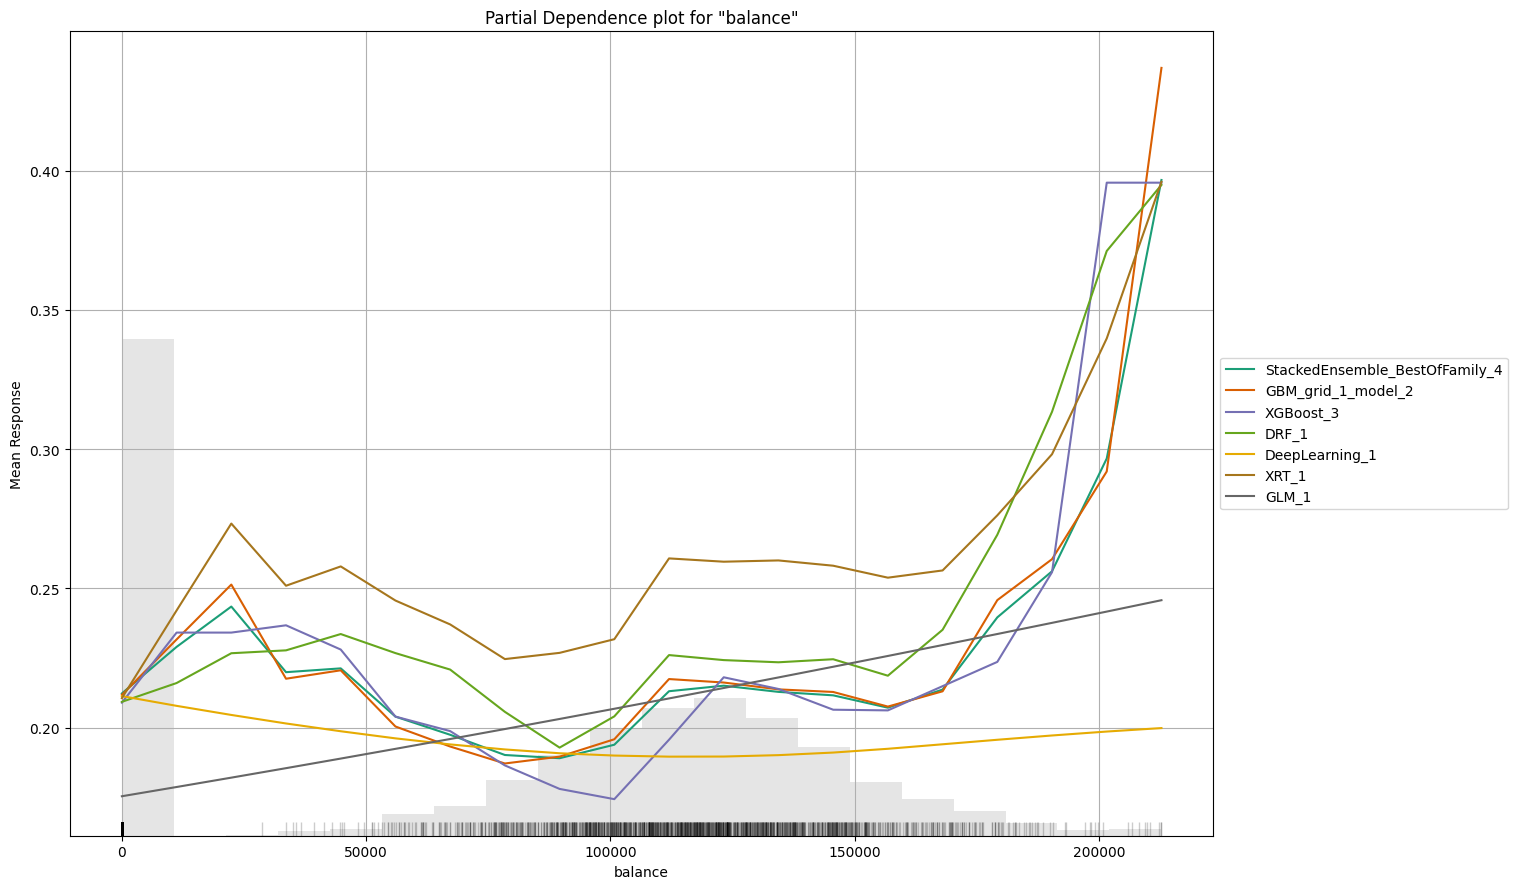

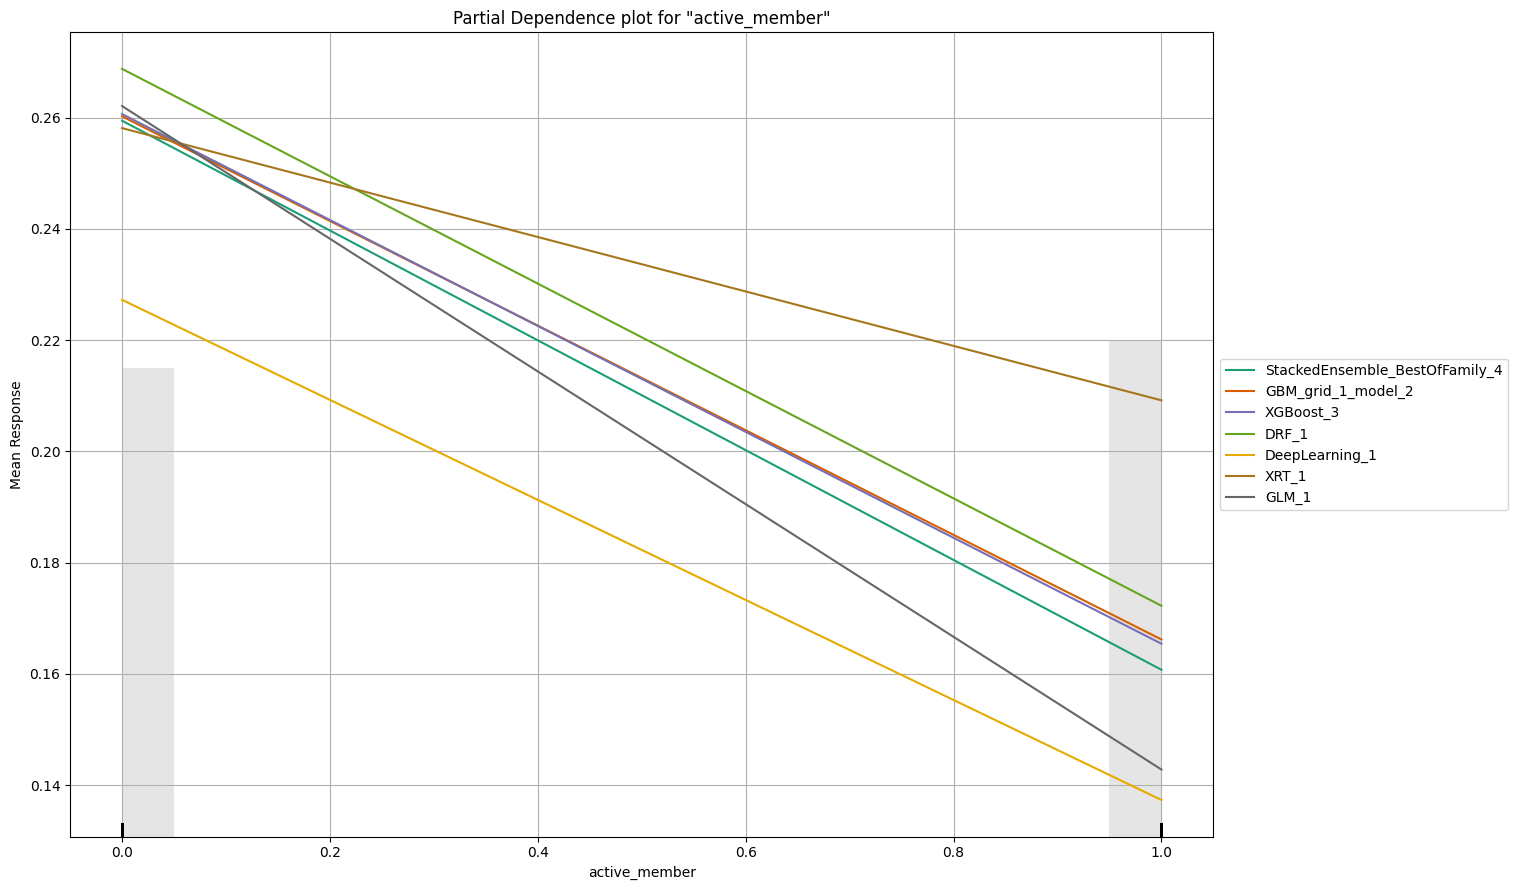

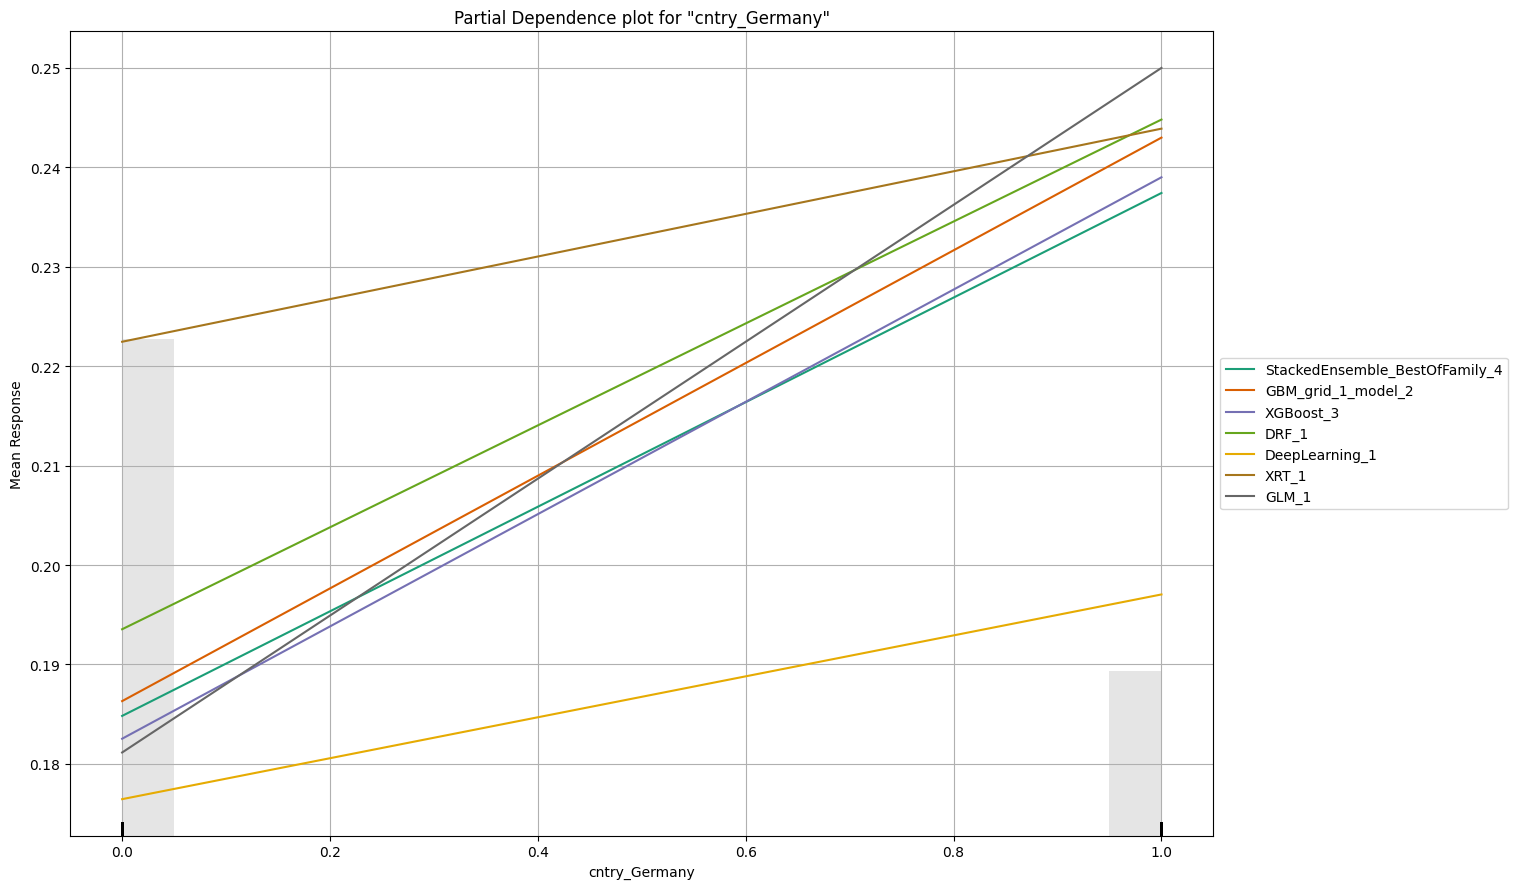

In [52]:
exa = auml.explain(hdf_test)

# Q5. In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model

In [53]:
#Compute VIF for all columns except target variable
Multic = df[X]
#Compute VIF
vif = pd.DataFrame()
vif["variables"] = Multic.columns
vif["VIF"] = [variance_inflation_factor(Multic.values, i) for i in range(Multic.shape[1])]
vif

variables       VIF
0       credit_score  1.001005
1                age  1.007221
2             tenure  1.002029
3            balance  1.337833
4    products_number  1.123300
5        credit_card  1.001612
6      active_member  1.002521
7   estimated_salary  1.000816
8       cntry_France       inf
9      cntry_Germany       inf
10       cntry_Spain       inf
11     gender_Female       inf
12       gender_Male       inf

In [54]:
results = smf.ols('churn ~ credit_score + age + tenure + balance + products_number + credit_card + active_member + estimated_salary + cntry_France + cntry_Spain + cntry_Germany + gender_Female + gender_Male', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  churn   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     195.4
Date:                Tue, 19 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:14:11   Log-Likelihood:                -3866.1
No. Observations:                9574   AIC:                             7756.
Df Residuals:                    9562   BIC:                             7842.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1643      0.019     -8.601      0.000      -0.202      -0.127
credit_score     -4.061e-05   3.86e-05     -1.052      0.293      -0.000    3.51e-05
age                  0.0162      0.000     37.528      0.000       0.015       0.017
tenure              -0.0014      0.001     -1.068      0.285      -0.004       0.001
balance           2.707e-07   6.87e-08      3.942      0.000    1.36e-07    4.05e-07
products_number     -0.0168      0.007     -2.489      0.013      -0.030      -0.004
credit_card         -0.0042      0.008     -0.518      0.604      -0.020       0.012
active_member       -0.1135      0.007    -15.295      0.000      -0.128      -0.099
estimated_salary  5.818e-08   6.45e-08      0.903      0.367   -6.82e-08    1.85e-07
cntry_France        -0.0945      0.008    -12.372      0.000      -0.109      -0.079
cntry_Spain         -0.0943      0.009    -11.045      0.000      -0.111      -0.078
cntry_Germany        0.0244      0.010      2.537      0.011       0.006       0.043
gender_Female       -0.0461      0.010     -4.460      0.000      -0.066      -0.026
gender_Male         -0.1182      0.010    -11.624      0.000      -0.138      -0.098
==============================================================================
Omnibus:                     1406.491   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2113.491
Skew:                           1.139   Prob(JB):                         0.00
Kurtosis:                       3.334   Cond. No.                     1.10e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.55e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Calculating VIF and OLS for columns with VIF < 15 from above results

In [55]:
#Indicate which variables to compute VIF (VIF < 15)
Multic = df[['credit_score', 'age', 'tenure', 'balance', 'products_number','credit_card','active_member','estimated_salary']]
#Compute VIF
vif = pd.DataFrame()
vif["variables"] = Multic.columns
vif["VIF"] = [variance_inflation_factor(Multic.values, i) for i in range(Multic.shape[1])]
vif

variables        VIF
0      credit_score  22.255289
1               age  15.372434
2            tenure   3.882060
3           balance   2.649412
4   products_number   7.803511
5       credit_card   3.295522
6     active_member   1.995979
7  estimated_salary   3.901061

In [56]:
results = smf.ols('churn ~ credit_score + age + tenure + balance + products_number + credit_card + active_member + estimated_salary', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  churn   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     230.0
Date:                Tue, 19 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:14:11   Log-Likelihood:                -3994.7
No. Observations:                9574   AIC:                             8007.
Df Residuals:                    9565   BIC:                             8072.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3791      0.035    -10.825      0.000      -0.448      -0.310
credit_score     -3.674e-05   3.91e-05     -0.939      0.348      -0.000    3.99e-05
age                  0.0166      0.000     38.114      0.000       0.016       0.017
tenure              -0.0015      0.001     -1.180      0.238      -0.004       0.001
balance           6.274e-07   6.32e-08      9.922      0.000    5.03e-07    7.51e-07
products_number     -0.0045      0.007     -0.657      0.511      -0.018       0.009
credit_card         -0.0027      0.008     -0.328      0.743      -0.019       0.013
active_member       -0.1166      0.008    -15.519      0.000      -0.131      -0.102
estimated_salary   6.73e-08   6.53e-08      1.030      0.303   -6.07e-08    1.95e-07
==============================================================================
Omnibus:                     1470.787   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2253.842
Skew:                           1.179   Prob(JB):                         0.00
Kurtosis:                       3.306   Cond. No.                     1.31e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Dropping Unwanted Variables

In [57]:
df_new = df[['churn', 'credit_score', 'age', 'tenure', 'balance','products_number','credit_card','active_member','estimated_salary']].copy()
df_new.head()

churn  credit_score  age  tenure    balance  products_number  credit_card  \
0      1           619   42       2       0.00                1            1   
1      0           608   41       1   83807.86                1            0   
2      1           502   42       8  159660.80                3            1   
3      0           699   39       1       0.00                2            0   
4      0           850   43       2  125510.82                1            1   

   active_member  estimated_salary  
0              1         101348.88  
1              1         112542.58  
2              0         113931.57  
3              0          93826.63  
4              1          79084.10

In [58]:
df_new.corr()

churn  credit_score       age    tenure   balance  \
churn             1.000000     -0.015727  0.360155 -0.012880  0.115798   
credit_score     -0.015727      1.000000 -0.013295 -0.001402  0.008267   
age               0.360155     -0.013295  1.000000 -0.012169  0.042007   
tenure           -0.012880     -0.001402 -0.012169  1.000000 -0.014133   
balance           0.115798      0.008267  0.042007 -0.014133  1.000000   
products_number  -0.050059      0.011331 -0.033457  0.015848 -0.305218   
credit_card      -0.007608     -0.002005 -0.013111  0.020917 -0.012355   
active_member    -0.141601      0.020273  0.012487 -0.027300 -0.006465   
estimated_salary  0.010244      0.001830 -0.004385  0.009919  0.010545   

                  products_number  credit_card  active_member  \
churn                   -0.050059    -0.007608      -0.141601   
credit_score             0.011331    -0.002005       0.020273   
age                     -0.033457    -0.013111       0.012487   
tenure                   0.015848     0.020917      -0.027300   
balance                 -0.305218    -0.012355      -0.006465   
products_number          1.000000     0.001837       0.011425   
credit_card              0.001837     1.000000      -0.011657   
active_member            0.011425    -0.011657       1.000000   
estimated_salary         0.011331    -0.011916      -0.008896   

                  estimated_salary  
churn                     0.010244  
credit_score              0.001830  
age                      -0.004385  
tenure                    0.009919  
balance                   0.010545  
products_number           0.011331  
credit_card              -0.011916  
active_member            -0.008896  
estimated_salary          1.000000

# Q8. Which independent variables are significant?

We can say that age, balance and product_number are important independent variables

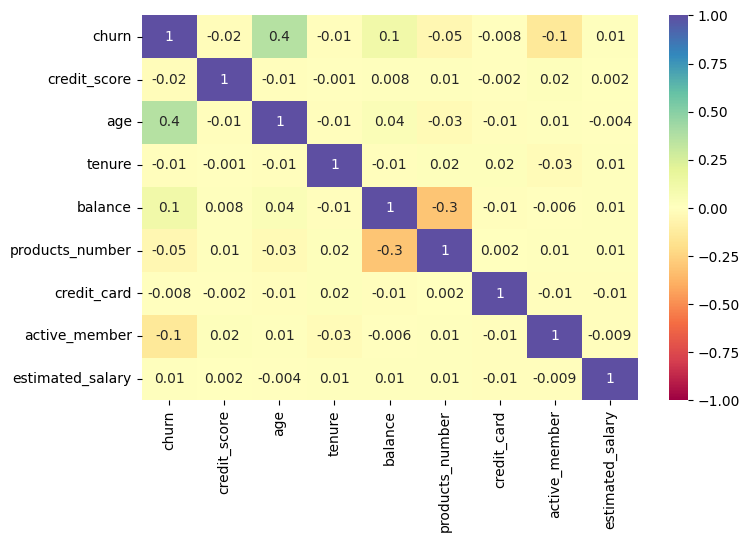

In [59]:
plt.rcParams['figure.figsize']=[8, 5]
sns.heatmap(df_new.corr(),  annot = True ,fmt = '.1g', vmin = -1, vmax = 1, center = 0, cmap = 'Spectral');

#Performing AutoML with new dataframe

In [60]:
hf_new = h2o.H2OFrame(df_new)
hf_new.shape

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


(9574, 9)

In [61]:
hf_new['churn'] = hf_new['churn'].asfactor()

In [62]:
#Seperate Dependent variable from Independent variable
X_new=hf_new.columns
y_new_numeric ='churn'
X_new.remove(y_new_numeric)
print(X_new)

['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']


In [63]:
# Create a 80/20 train/test split
pct_rows=0.80
hf_new_train, hf_new_test = hf_new.split_frame([pct_rows])

In [64]:
auml_new = H2OAutoML(max_runtime_secs=run_time, seed=1)
auml_new.train(x=X_new,y=y_new_numeric,training_frame=hf_new_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_2_20240319_151413


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       14/29
# GBM base models (used / total)           6/12
# XGBoost base models (used / total)       4/11
# DeepLearning base models (used / total)  3/3
# DRF base models (used / total)           1/2
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08667500288281074
RMSE: 0.2944061868962858
LogLoss: 0.28897413767266056
AUC: 0.906723465422948
AUCPR: 0.7731499305340016
Gini: 0.813446930845896
Null degrees of freedom: 7666
Residual degrees of freedom: 7652
Null deviance: 7616.269569973389
Residual deviance: 4431.129427072577
AIC: 4461.129427072577

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3305020490318776
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      5721  433   0.0704   (433.0/6154.0)
1      502   1011  0.3318   (502.0/1513.0)
Total  6223  1444  0.122    (935.0/7667.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330502     0.683801  193
max f2                       0.162375     0.747061  270
max f0point5                 0.514408     0.745726  133
max accuracy                 0.474068     0.88457   146
max precision                0.992161     1         0
max recall                   0.0175344    1         394
max specificity              0.992161     1         0
max absolute_mcc             0.346847     0.609983  187
max min_per_class_accuracy   0.191809     0.817581  254
max mean_per_class_accuracy  0.176371     0.819713  262
max tns                      0.992161     6154      0
max fns                      0.992161     1508      0
max fps                      0.0121721    6154      399
max tps                      0.0175344    1513      394
max tnr                      0.992161     1         0
max fnr                      0.992161     0.996695  0
max fpr                      0.0121721    1         399
max tpr                      0.0175344    1         394

Gains/Lift Table: Avg response rate: 19.73 %, avg score: 19.94 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010043                    0.958647           5.06742    5.06742            1                0.974186   1                           0.974186            0.0508923       0.0508923                  406.742   406.742            0.0508923
2        0.0200861                   0.923611           5.06742    5.06742            1                0.941301   1                           0.957743            0.0508923       0.101785                   406.742   406.742            0.101785
3        0.0299987                   0.89707            4.93406    5.02335            0.973684         0.909623   0.991304                    0.941843            0.0489095       0.150694                   393.406   402.335            0.150369
4        0.040

In [65]:
print(auml_new.leaderboard)

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
StackedEnsemble_AllModels_3_AutoML_2_20240319_151413     0.846497   0.344784  0.670545                0.250862  0.323713  0.10479
StackedEnsemble_BestOfFamily_4_AutoML_2_20240319_151413  0.846018   0.345784  0.667755                0.253706  0.324321  0.105184
GBM_grid_1_AutoML_2_20240319_151413_model_2              0.845548   0.34693   0.664761                0.245995  0.324538  0.105325
StackedEnsemble_AllModels_2_AutoML_2_20240319_151413     0.845125   0.345921  0.66838                 0.24677   0.324329  0.105189
StackedEnsemble_BestOfFamily_3_AutoML_2_20240319_151413  0.844394   0.346347  0.668448                0.249745  0.324422  0.105249
GBM_grid_1_AutoML_2_20240319_151413_model_3              0.844071   0.347709  0.665769                0.248472  0.324674  0.105413
StackedEnsemble_AllModels_1_AutoML_2_20240319_151413     0.843315   0.348612  0.6638

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  --------  ------------------  -------------------------  ---------------
GBM_grid_1_AutoML_2_20240319_151413_model_2              0.836124   0.378165  0.660993                0.247356  0.343029  0.117669                 507                   0.012012  GBM
StackedEnsemble_AllModels_3_AutoML_2_20240319_151413     0.834704   0.380163  0.656897                0.238196  0.344502  0.118682                2258                   0.10216   StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_2_20240319_151413  0.834382   0.37906   0.659715                0.245545  0.343619  0.118074                1322                   0.050313  StackedEnsemble
GBM_grid_1_AutoML_2_20240319_151413_model_3              0.833805   0.382801  0.649988                0.237822  0.345974  0.119698                 816                   0.018198  GBM
StackedEnsemble_AllModels_2_AutoML_2_20240319_151413     0.833265   0.381931  0.652942                0.241548  0.345562  0.119413                 996                   0.099214  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_2_20240319_151413     0.833074   0.383448  0.648193                0.240886  0.346133  0.119808                1139                   0.048856  StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_2_20240319_151413  0.832881   0.381358  0.654292                0.242888  0.344996  0.119022                 866                   0.034297  StackedEnsemble
GBM_2_AutoML_2_20240319_151413                           0.832415   0.384807  0.645093                0.24904   0.346843  0.1203                   782                   0.020749  GBM
XGBoost_3_AutoML_2_20240319_151413                       0.832124   0.384807  0.648835                0.264072  0.346524  0.120079                 583                   0.007463  XGBoost
GBM_1_AutoML_2_20240319_151413                           0.831332   0.384973  0.644272                0.244356  0.346464  0.120038                1127                   0.024172  GBM
GBM_grid_1_AutoML_2_20240319_151413_model_7              0.830821   0.39799   0.65086                 0.261048  0.351939  0.123861                 269                   0.009376  GBM
StackedEnsemble_BestOfFamily_1_AutoML_2_20240319_151413  0.830098   0.38581   0.643071                0.242425  0.346473  0.120043                 921                   0.028159  StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_2_20240319_151413  0.829983   0.386059  0.642387                0.244428  0.346992  0.120404                 786                   0.039454  StackedEnsemble
GBM_grid_1_AutoML_2_20240319_151413_model_6              0.829798   0.385532  0.646179                0.246016  0.346005  0.11972                  706                   0.019485  GBM
GBM_5_AutoML_2_20240319_151413                           0.829248   0.387245  0.642569                0.256811  0.347885  0.121024                 513                   0.013449  GBM
XGBoost_grid_1_AutoML_2_20240319_151413_model_7          0.828055   0.390482  0.641965                0.250364  0.348192  0.121238                 740                   0.009886  XGBoost
GBM_4_AutoML_2_20240319_151413                           0.825586   0.391957  0.636485                0.256923  0.349974  0.122482                 597                   0.021471  GBM
GBM_3_AutoML_2_20240319_151413                           0.825454   0.392875  0.633847                0.24991   0.350966  0.123177                 554                   0.014419  GBM
XGBoost_grid_1_AutoML_2_20240319_151413_model_4          0.823342   0.402717  0.630865                0.264008  0.353853  0.125212                 778                   0.00738   XGBoost
XGBoost_grid_1_AutoML_2_20240319_151413_model_3 

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_3_AutoML_2_20240319_151413

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2231228877952311
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      1245  247  0.1655   (247.0/1492.0)
1      129   286  0.3108   (129.0/415.0)
Total  1374  533  0.1972   (376.0/1907.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

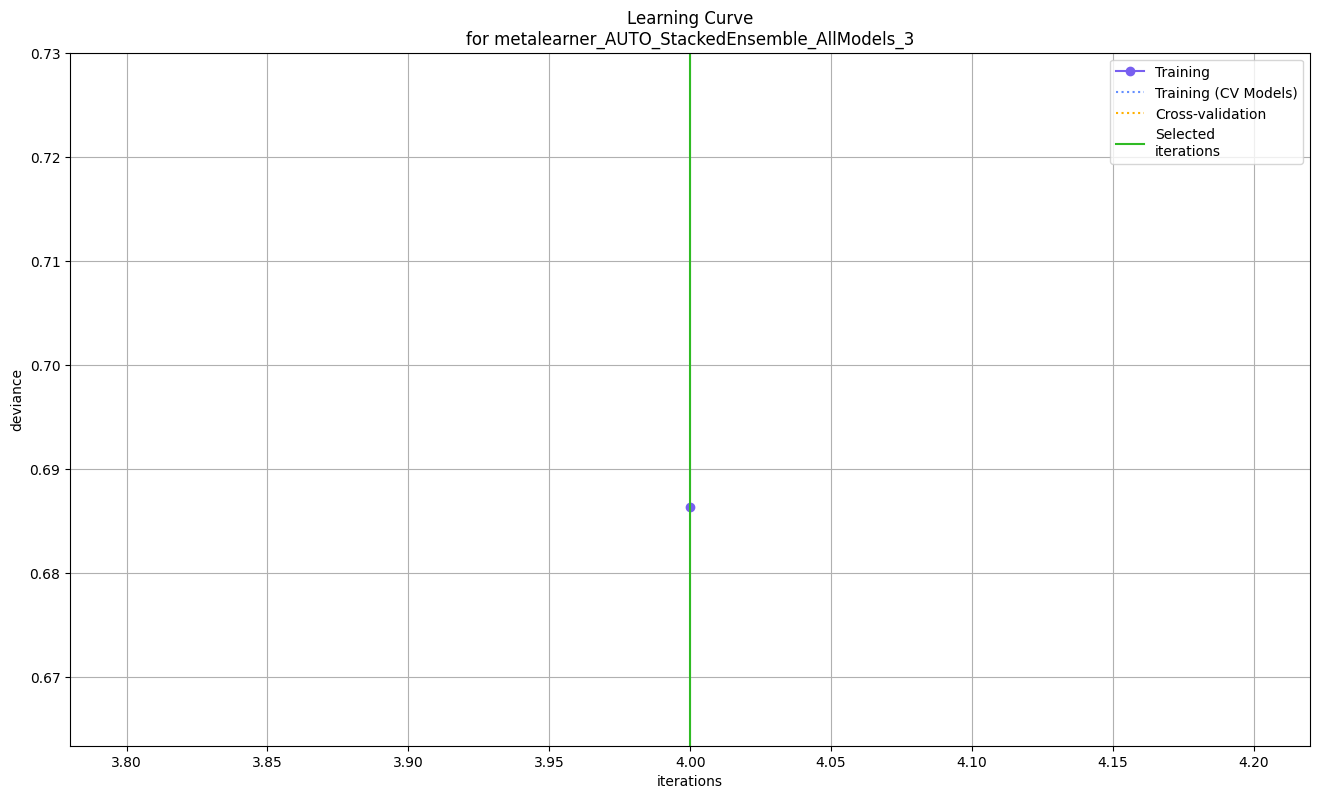

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

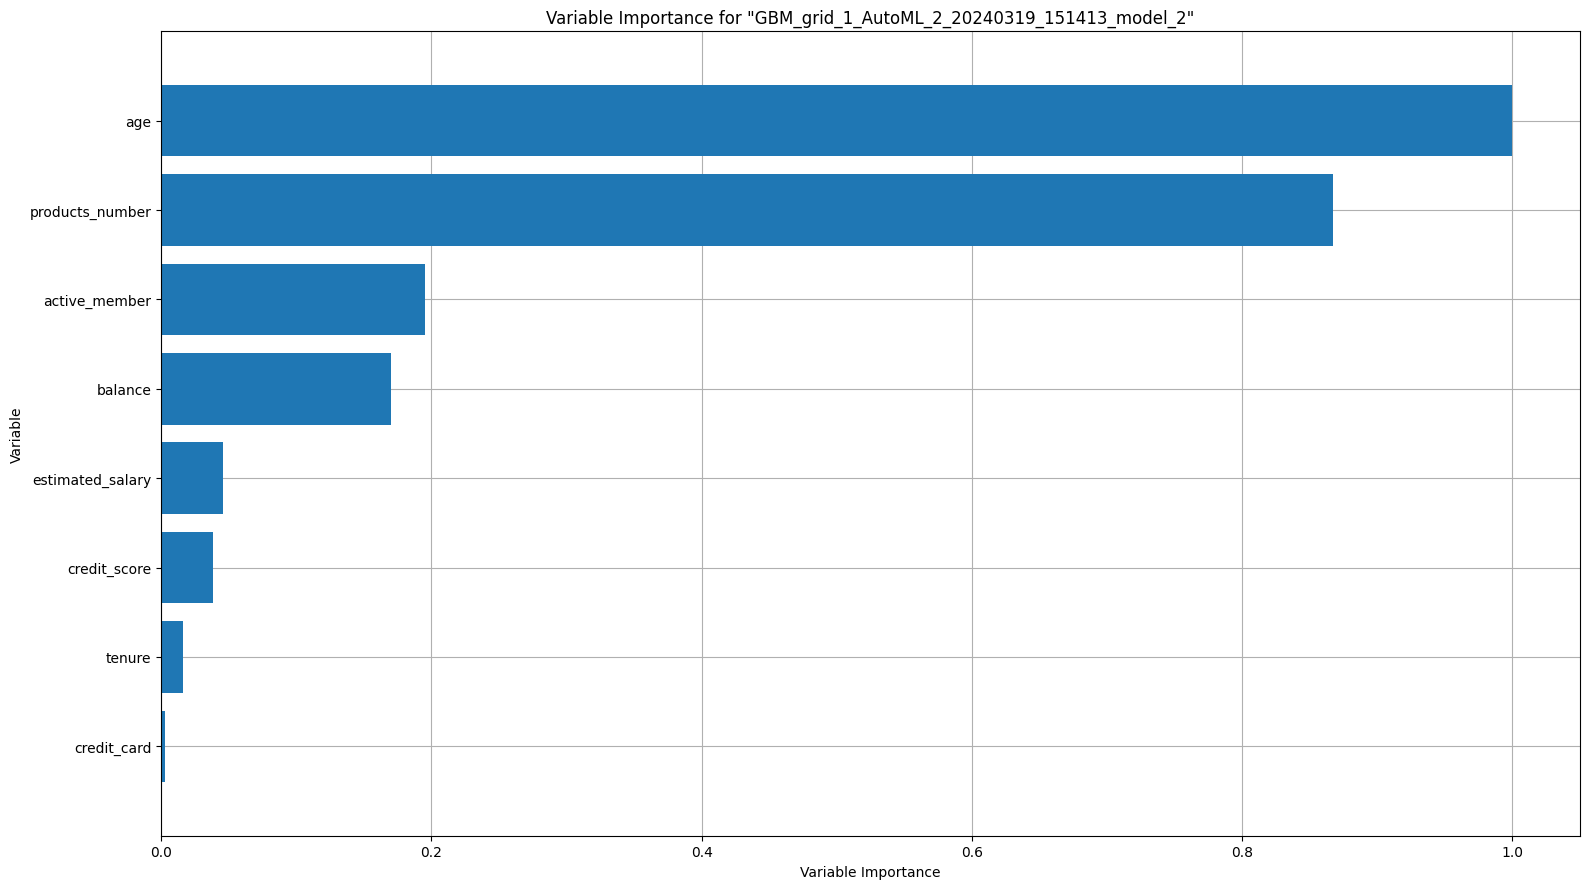

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

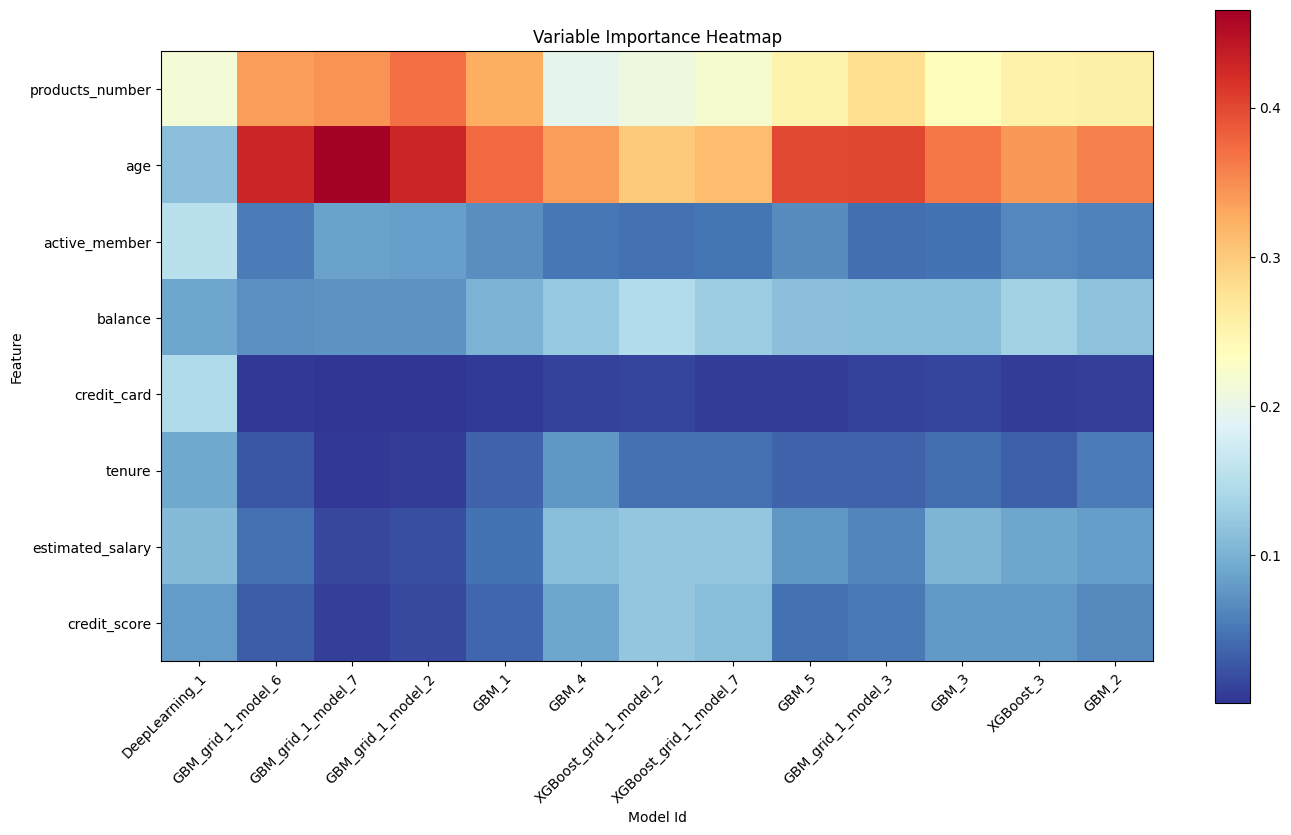

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

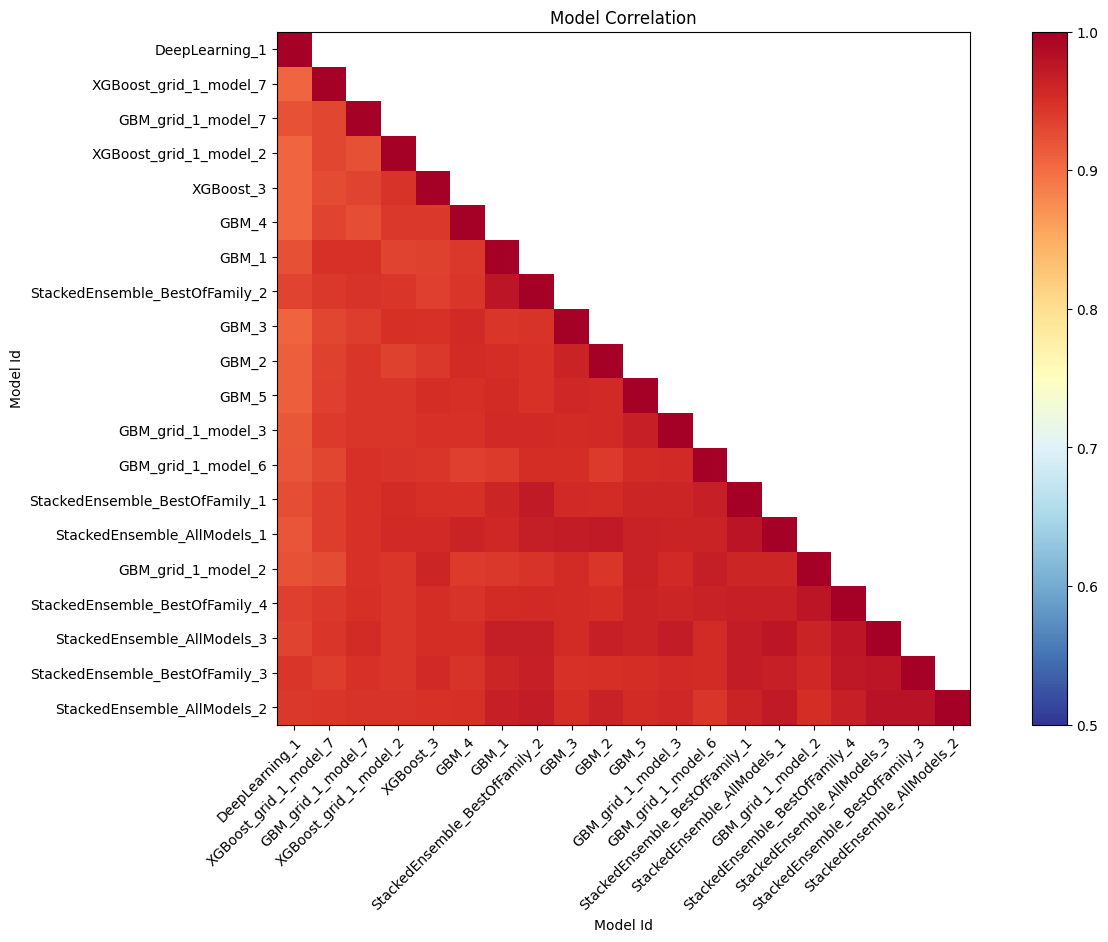

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

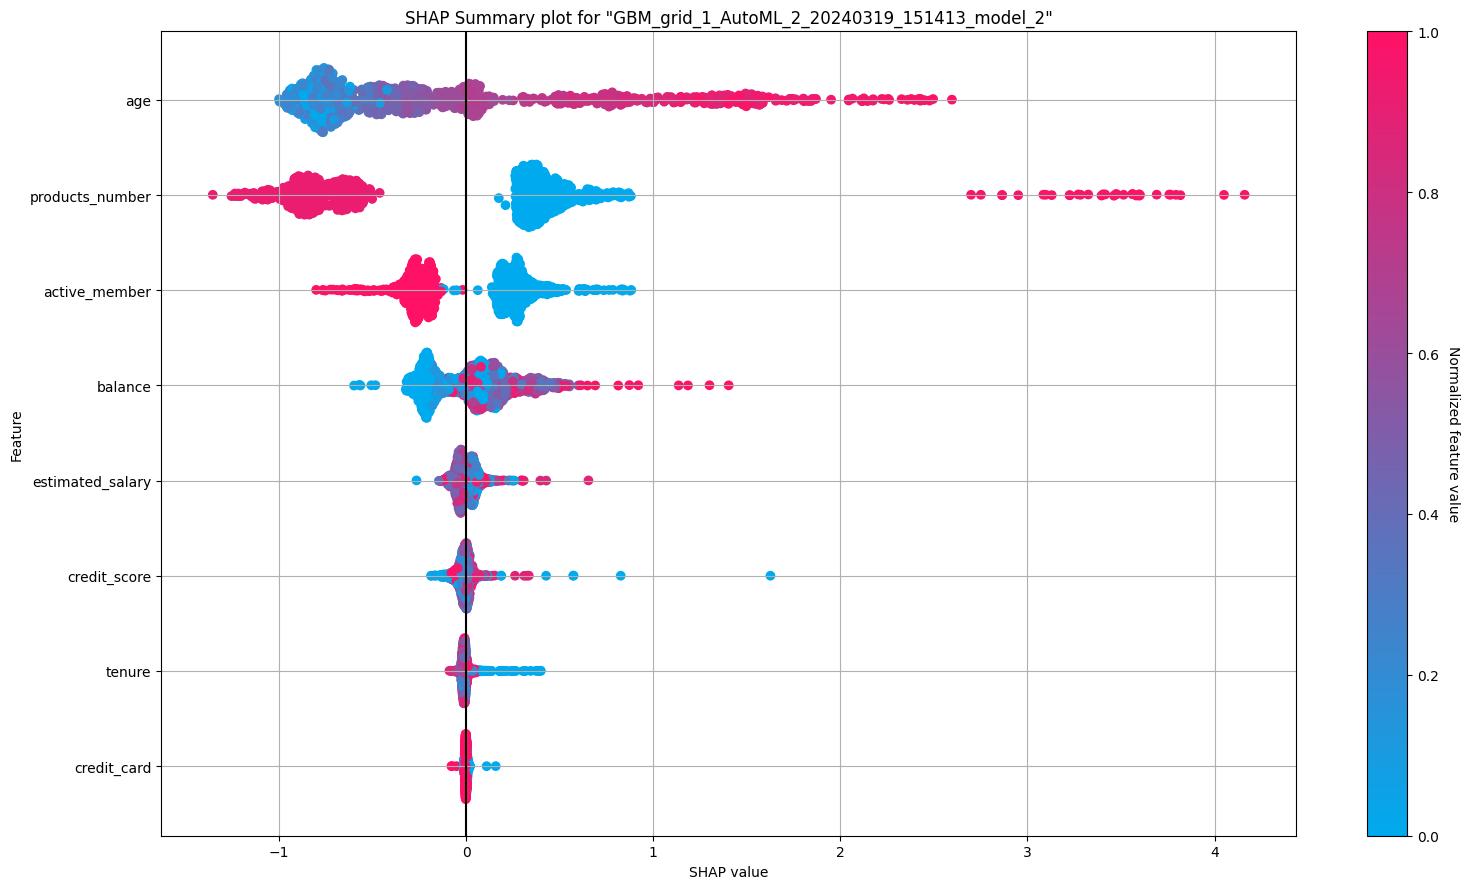

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

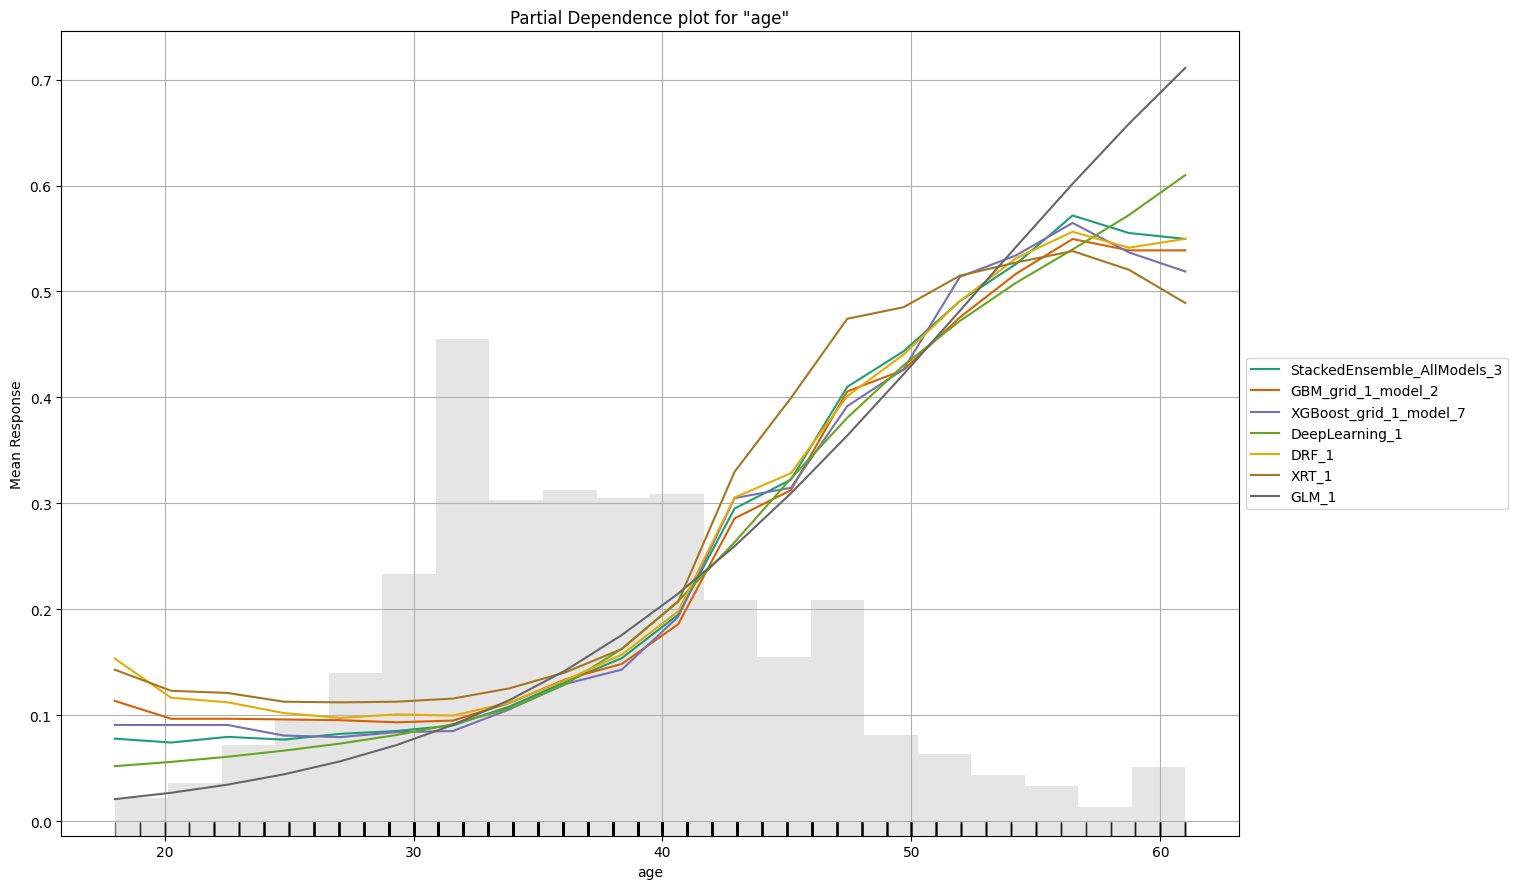

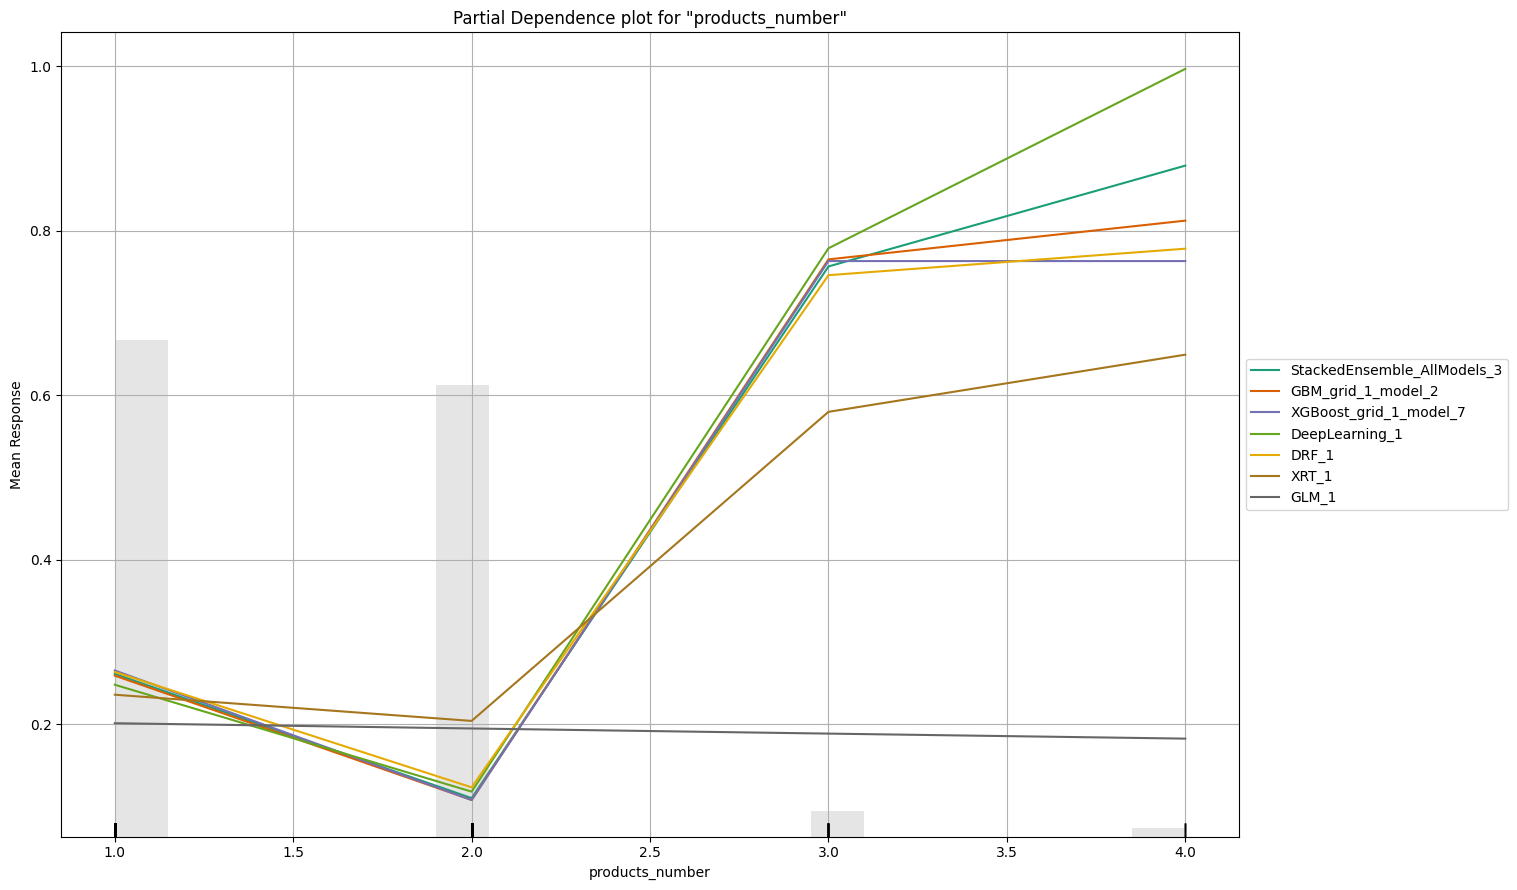

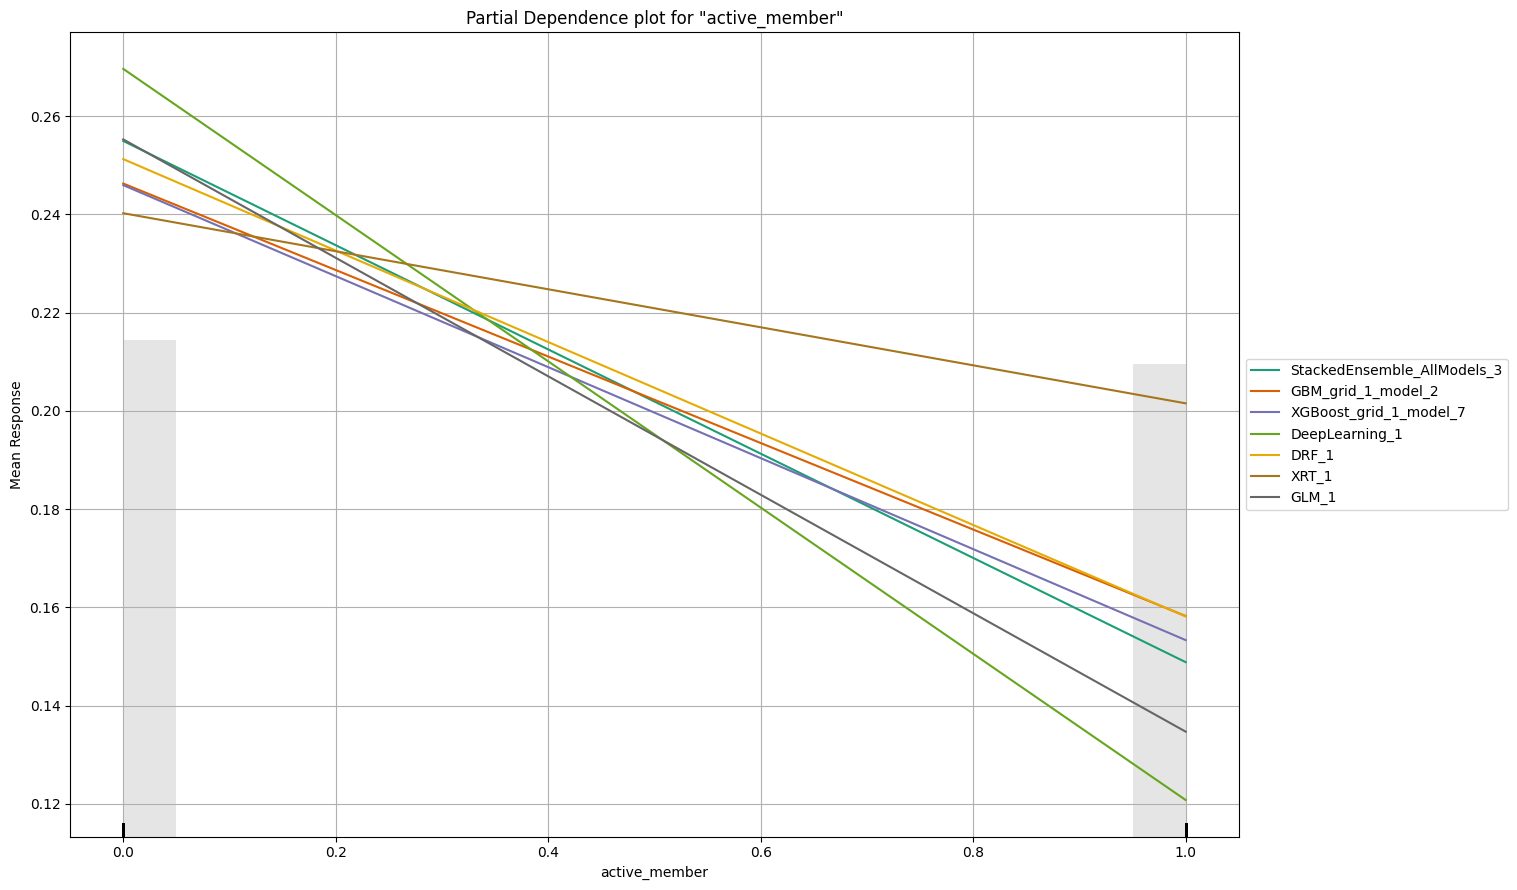

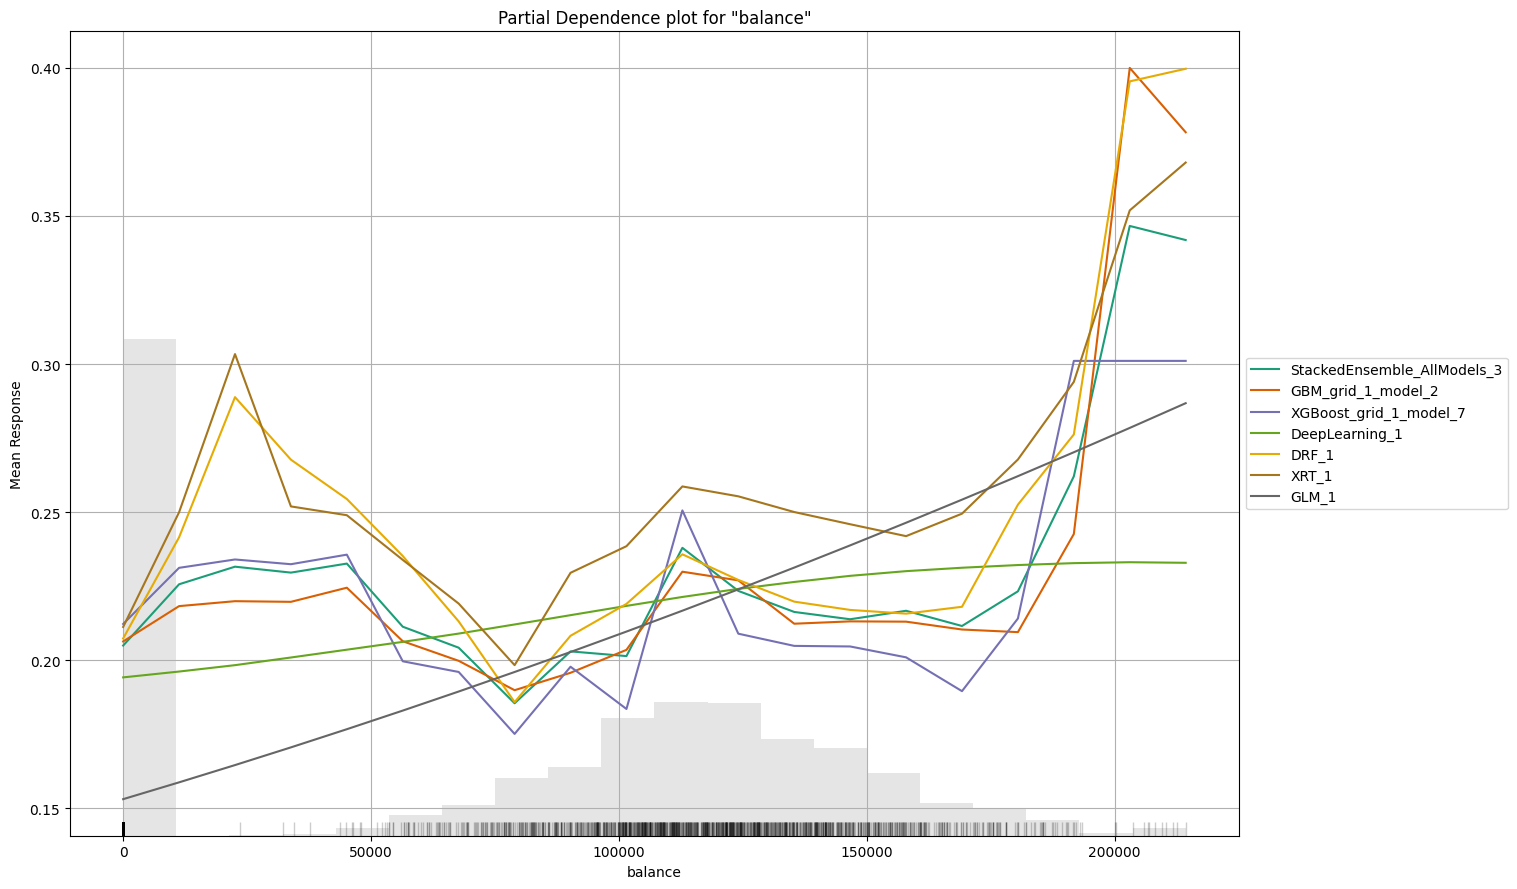

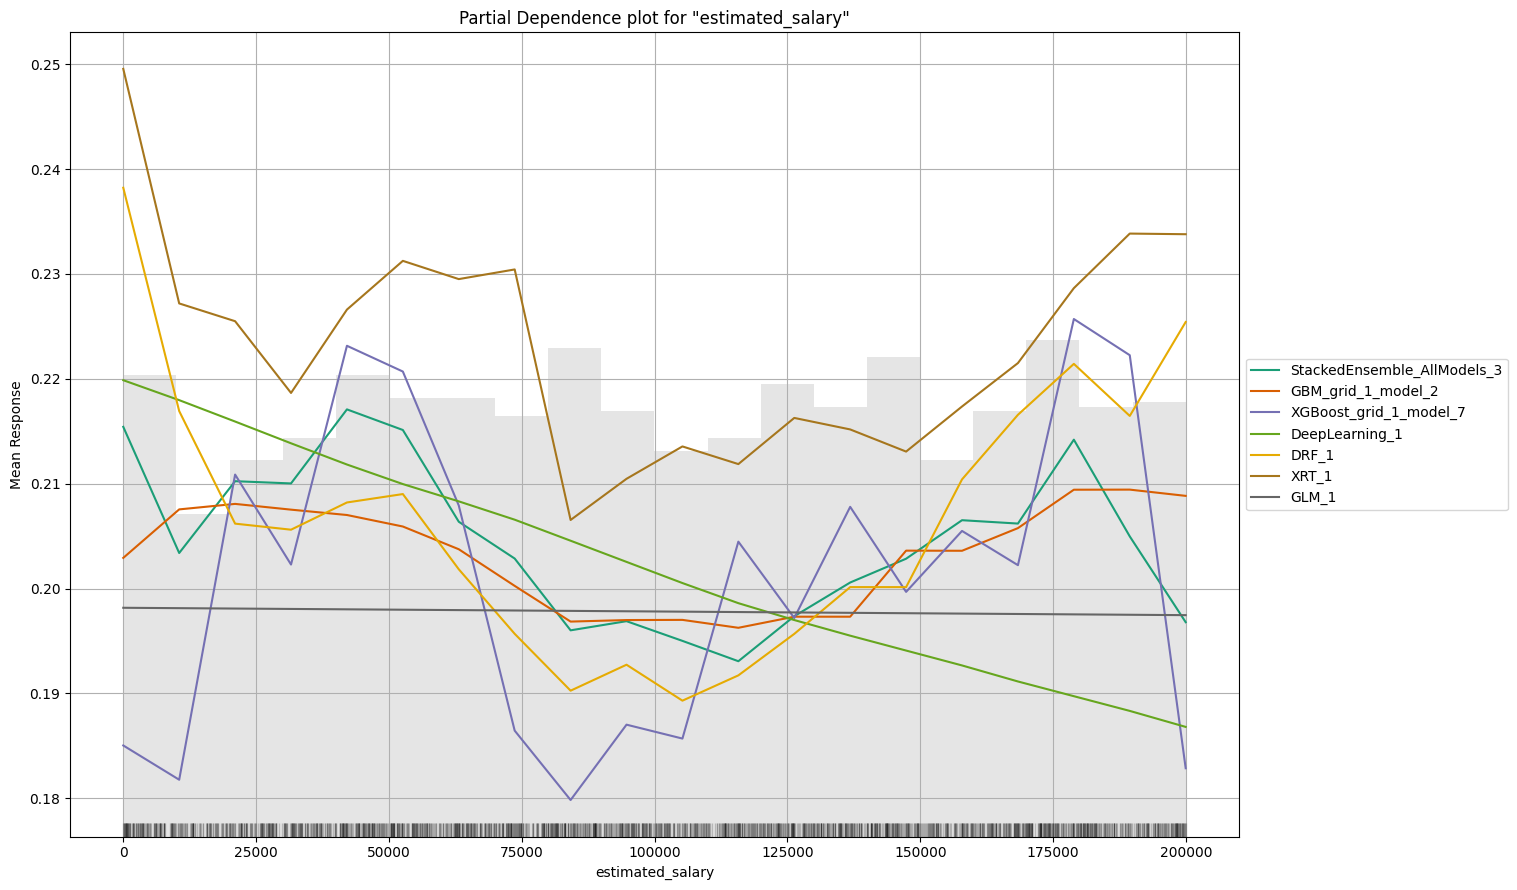

In [66]:
exa_new = auml_new.explain(hf_new_test)

# Q6. Does the model make sense?

Ans: Yes, The model's findings are meaningful, as it is reasonable to expect that certain age groups are more likely are to churn. <br>

Additionally, the model highlights that Product number, balance and active member is likely to have a significant impact on the churn.

# Q7. Does regularization help?

Using Ridge Regularization

In [67]:
hf_new = h2o.H2OFrame(df_new)
hf_new.shape

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


(9574, 9)

In [68]:
hf_new['churn'] = hf_new['churn'].asfactor()

In [69]:
#Seperate Dependent variable from Independent variable
X_new=hf_new.columns
y_new_numeric ='churn'
X_new.remove(y_new_numeric)
print(X_new)

['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']


In [70]:
# Create a 80/20 train/test split
pct_rows=0.80
hf_new_train, hf_new_test = hf_new.split_frame([pct_rows])

In [71]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
house_glm = H2OGeneralizedLinearEstimator(family = 'binomial', lambda_ = 0, compute_p_values = True)
house_glm_regularization = H2OGeneralizedLinearEstimator(family = 'binomial', lambda_ = .001, alpha = 0)

In [72]:
house_glm_regularization.train(x = X_new, y = y_new_numeric, training_frame = hf_new_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1710860856617_6015


GLM Model: summary
    family    link    regularization            number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Ridge ( lambda = 0.001 )  8                             8                              4                       py_967_sid_8511

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.13010102058079645
RMSE: 0.3606951906815455
LogLoss: 0.41551603094862816
AUC: 0.7757441169555646
AUCPR: 0.5132757294603081
Gini: 0.5514882339111291
Null degrees of freedom: 7633
Residual degrees of freedom: 7625
Null deviance: 7660.064449582559
Residual deviance: 6344.098760523655
AIC: 6362.098760523655

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25180057619648577
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      4870  1230  0.2016   (1230.0/6100.0)
1      596   938   0.3885   (596.0/1534.0)
Total  5466  2168  0.2392   (1826.0/7634.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.251801     0.506753  210
max f2                       0.134862     0.619104  290
max f0point5                 0.411154     0.518593  132
max accuracy                 0.513191     0.821719  92
max precision                0.864433     1         0
max recall                   0.00873144   1         399
max specificity              0.864433     1         0
max absolute_mcc             0.353721     0.376671  157
max min_per_class_accuracy   0.197414     0.707869  245
max mean_per_class_accuracy  0.216747     0.711282  232
max tns                      0.864433     6100      0
max fns                      0.864433     1533      0
max fps                      0.00873144   6100      399
max tps                      0.00873144   1534      399
max tnr                      0.864433     1         0
max fnr                      0.864433     0.999348  0
max fpr                      0.00873144   1         399
max tpr                      0.00873144   1         399

Gains/Lift Table: Avg response rate: 20.09 %, avg score: 20.09 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100865                   0.740959           4.71801   4.71801            0.948052         0.790222   0.948052                    0.790222            0.047588        0.047588                   371.801   371.801            0.0469323
2        0.0200419                   0.677193           3.79788   4.26095            0.763158         0.703529   0.856209                    0.747159            0.0378096       0.0853977                  279.788   326.095            0.0817911
3        0.0299974                   0.634637           3.27403   3.93342            0.657895         0.653283   0.790393                    0.716004            0.0325945       0.117992                   227.403   293.342            0.110123
4        0.0400838                   0.603863           2.52058   3.5779             0.506494         0.618884   0.718954                    0.691565            0.0254237       0.143416                   152.058   257.79             0.129318
5        0.0500393         

Impact of regularization

**MSE (Mean Squared Error):**

Before regularization: 0.09896

After regularization: 0.12881

Increase in MSE indicates that the model's predictive accuracy has decreased after regularization.

**RMSE (Root Mean Squared Error):**

Before regularization: 0.31457

After regularization: 0.35890

Similar to MSE, an increase in RMSE suggests a decrease in the model's accuracy.

# Q9. Which hyperparameters are important?

We have only used runtime and memeory as hyperparameter in our process thus those are important parameters to us

# References and License

Analytics Vidya

https://stackoverflow.com/questions/66324765/get-accuracy-metric-from-leaderboard-function-when-using-h20-ai/66325195#66325195

medium: towardsdatascience

Seaborn: statistical data visualization

geeksforgeeks

https://docs.h2o.ai/

Assignment_1_ML_Data_Cleaning_and_Feature_Selection.ipynb

MIT License

Copyright (c) 2024 anshvaghela2099

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.